In [1]:
import numpy as np
import pandas as pd

import json

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

In [2]:
# Read the JSON file into Python
with open('restrictions_and_quarantine.json','r') as business_as_usual:
    bas_data = json.load(business_as_usual)
    
# Convert the data into a dataframe
df_bas = pd.DataFrame(bas_data['data'])
df_muni_bas = pd.DataFrame(bas_data['city_names'])
df_Reff_bas = pd.DataFrame(bas_data['R_eff'])

# Get the vector of R_eff
Reff_bas = np.array(df_Reff_bas)

# Rename the column of municipalities
df_muni_bas.columns = ['muni_name']
ind = df_muni_bas.loc[df_muni_bas['muni_name'] == 'Banská Bystrica'].index[0]

# Read the JSON file into Python
with open('restrictions_and_quarantine_hp32.json','r') as superspreaders:
    superspreaders_data = json.load(superspreaders)
    
# Convert the data into a dataframe
df_ss = pd.DataFrame(superspreaders_data['data'])
df_muni_ss = pd.DataFrame(superspreaders_data['city_names'])
df_Reff_ss = pd.DataFrame(bas_data['R_eff'])

# Get the vector of R_eff
Reff_ss = np.array(df_Reff_ss)

In [3]:
### Linear increase in number of available Lung Ventilators
def get_num_of_ventilators(t_vec, t_start_adding_vents,
                           num_weeks_adding_vents, num_vent_init, num_vent_end):
    """
    Function computes the linear increase in the number of available ventilators.
    ------
    Inputs:
    - t_vec (np.array): Time vector in days
    - t_start_adding_vents (int): Day of the simulation at which we start adding ventilators
    - num_weeks_adding_vents (int): Number of weeks for which we are adding the ventilators
    - num_vent_init (int): Initial number of ventilators
    - num_vent_end (int): Final number of ventilators
    ------
    Outputs: 
    - num_vents(np.array): A vector of numbers of ventilators at each day.
    """

    
    # Time when we stop adding ventilators  (end of June)
    t_stop_adding_vents = (t_start_adding_vents + num_weeks_adding_vents * 7)

    # Ramp up of the ventilators 
    num_vents = num_vent_init*np.ones(len(t_vec))

    # Assume linear increase in the number of ventilators
    for ind in np.arange(t_start_adding_vents,t_stop_adding_vents):
        num_vents[ind] = num_vents[ind] + (num_vent_end - num_vent_init)/(num_weeks_adding_vents * 7)*(ind - t_start_adding_vents)
        
    # Set the number of ventilators to be constant after the end of ramp
    max_vents = np.argmax(num_vents)
    num_vents[max_vents:] = num_vent_end
    num_vents = np.floor(num_vents)
    
    return num_vents


In [4]:
### Set up the parameters
# Proportion of infected individuals that are symptomatic 
asym_ratio = 0.4

# Empty lists of different states individuals
S_vec_bas = np.zeros(len(df_bas)) # Susceptible
I_vec_bas = np.zeros(len(df_bas)) # Infected (Symptomatic + Asymptomatic)
Sym_vec_bas = np.zeros(len(df_bas)) # Symptomatic Individuals
Asym_vec_bas = np.zeros(len(df_bas)) # Asymptomatic indiviudals 
R_vec_bas = np.zeros(len(df_bas)) # Recovered
D_vec_bas = np.zeros(len(df_bas)) # Dead
H_vec_bas = np.zeros(len(df_bas)) # Hospitalized
C_vec_bas = np.zeros(len(df_bas)) # Hospitalized in ICU
NC_vec_bas = np.zeros(len(df_bas)) # Newly infected individuals
NNew_vec_bas = np.zeros(len(df_bas)) # Daily  increase of infected individuals

# Empty lists of different states individuals
S_vec_ss = np.zeros(len(df_ss)) # Susceptible
I_vec_ss = np.zeros(len(df_ss)) # Infected (Symptomatic + Asymptomatic)
Sym_vec_ss = np.zeros(len(df_ss)) # Symptomatic Individuals
Asym_vec_ss = np.zeros(len(df_ss)) # Asymptomatic indiviudals 
R_vec_ss = np.zeros(len(df_ss)) # Recovered
D_vec_ss = np.zeros(len(df_ss)) # Dead
H_vec_ss = np.zeros(len(df_ss)) # Hospitalized
C_vec_ss = np.zeros(len(df_ss)) # Hospitalized in ICU
NC_vec_ss = np.zeros(len(df_ss)) # Newly infected individuals
NNew_vec_ss = np.zeros(len(df_bas)) # Daily  increase of infected individuals

# Get the time vector of Business as usual
time_vec_bas = np.arange(len(df_bas))


# Get the time vector of Business as usual
time_vec_ss = np.arange(len(df_ss))

# Get the vectors of states
for i in range(len(df_bas)):
    S_vec_bas[i] = np.sum(df_bas['susceptible'][i])
    I_vec_bas[i] = np.sum(df_bas['infected'][i])
    Sym_vec_bas[i] = (1-asym_ratio) * I_vec_bas[i]
    Asym_vec_bas[i] = asym_ratio * I_vec_bas[i]
    R_vec_bas[i] = np.sum(df_bas['immune'][i])
    D_vec_bas[i] = np.sum(df_bas['dead'][i])
    H_vec_bas[i] = np.sum(df_bas['hospitalized'][i])
    C_vec_bas[i] = np.sum(df_bas['critical_care'][i])
    NC_vec_bas[i] = np.sum(df_bas['new_cases'][i])
    
    
# Get the vectors of states
for i in range(len(df_ss)):
    S_vec_ss[i] = np.sum(df_ss['susceptible'][i])
    I_vec_ss[i] = np.sum(df_ss['infected'][i])
    Sym_vec_ss[i] = (1-asym_ratio) * I_vec_ss[i]
    Asym_vec_ss[i] = asym_ratio * I_vec_ss[i]
    R_vec_ss[i] = np.sum(df_ss['immune'][i])
    D_vec_ss[i] = np.sum(df_ss['dead'][i])
    H_vec_ss[i] = np.sum(df_ss['hospitalized'][i])
    C_vec_ss[i] = np.sum(df_ss['critical_care'][i])
    NC_vec_ss[i] = np.sum(df_ss['new_cases'][i])
    


In [5]:
Sym_vec_bas[14]

1178.3999999999999

In [6]:
def plotting_time_course_two(input_files, 
                             plot_municipality=False, muni_string='Banská Bystrica',
                             plot_intermittent_NPI=False,
                             title_str='',
                             asym_ratio=0.4,
                             t_measures_on=None, t_measures_off=None, measures_string='Social distancing',
                             t_ext_measures_on=None, t_ext_measures_off=None,
                             ext_measures_string='Social Distancing of Elderly',
                             t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                             plot_deaths=False):
    
    
    # Read the JSON file into Python
    with open(input_files[0],'r') as business_as_usual:
        bas_data = json.load(business_as_usual)

    # Convert the data into a dataframe
    df_bas = pd.DataFrame(bas_data['data'])
    df_muni_bas = pd.DataFrame(bas_data['city_names'])
    df_Reff_bas = pd.DataFrame(bas_data['R_eff'])

    # Get the vector of R_eff
    Reff_bas = np.array(df_Reff_bas)

    # Rename the column of municipalities
    df_muni_bas.columns = ['muni_name']
    ind = df_muni_bas.loc[df_muni_bas['muni_name'] == 'Banská Bystrica'].index[0]

    # Read the JSON file into Python
    with open(input_files[1],'r') as superspreaders:
        superspreaders_data = json.load(superspreaders)

    # Convert the data into a dataframe
    df_ss = pd.DataFrame(superspreaders_data['data'])
    df_muni_ss = pd.DataFrame(superspreaders_data['city_names'])
    df_Reff_ss = pd.DataFrame(bas_data['R_eff'])

    # Get the vector of R_eff
    Reff_ss = np.array(df_Reff_ss)

    # Empty lists of different states individuals
    S_vec_bas = np.zeros(len(df_bas)) # Susceptible
    I_vec_bas = np.zeros(len(df_bas)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec_bas = np.zeros(len(df_bas)) # Symptomatic Individuals
    Asym_vec_bas = np.zeros(len(df_bas)) # Asymptomatic indiviudals 
    R_vec_bas = np.zeros(len(df_bas)) # Recovered
    D_vec_bas = np.zeros(len(df_bas)) # Dead
    H_vec_bas = np.zeros(len(df_bas)) # Hospitalized
    C_vec_bas = np.zeros(len(df_bas)) # Hospitalized in ICU
    NC_vec_bas = np.zeros(len(df_bas)) # Newly infected individuals
    NNew_vec_bas = np.zeros(len(df_bas)) # Daily  increase of infected individuals

    # Empty lists of different states individuals
    S_vec_ss = np.zeros(len(df_ss)) # Susceptible
    I_vec_ss = np.zeros(len(df_ss)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec_ss = np.zeros(len(df_ss)) # Symptomatic Individuals
    Asym_vec_ss = np.zeros(len(df_ss)) # Asymptomatic indiviudals 
    R_vec_ss = np.zeros(len(df_ss)) # Recovered
    D_vec_ss = np.zeros(len(df_ss)) # Dead
    H_vec_ss = np.zeros(len(df_ss)) # Hospitalized
    C_vec_ss = np.zeros(len(df_ss)) # Hospitalized in ICU
    NC_vec_ss = np.zeros(len(df_ss)) # Newly infected individuals
    NNew_vec_ss = np.zeros(len(df_bas)) # Daily  increase of infected individuals

    # Get the time vector of Business as usual
    time_vec_bas = np.arange(len(df_bas))


    # Get the time vector of Business as usual
    time_vec_ss = np.arange(len(df_ss))

    # Get the vectors of states
    for i in range(len(df_bas)):
        S_vec_bas[i] = np.sum(df_bas['susceptible'][i])
        I_vec_bas[i] = np.sum(df_bas['infected'][i])
        Sym_vec_bas[i] = (1-asym_ratio) * I_vec_bas[i]
        Asym_vec_bas[i] = asym_ratio * I_vec_bas[i]
        R_vec_bas[i] = np.sum(df_bas['immune'][i])
        D_vec_bas[i] = np.sum(df_bas['dead'][i])
        H_vec_bas[i] = np.sum(df_bas['hospitalized'][i])
        C_vec_bas[i] = np.sum(df_bas['critical_care'][i])
        NC_vec_bas[i] = np.sum(df_bas['new_cases'][i])


    # Get the vectors of states
    for i in range(len(df_ss)):
        S_vec_ss[i] = np.sum(df_ss['susceptible'][i])
        I_vec_ss[i] = np.sum(df_ss['infected'][i])
        Sym_vec_ss[i] = (1-asym_ratio) * I_vec_ss[i]
        Asym_vec_ss[i] = asym_ratio * I_vec_ss[i]
        R_vec_ss[i] = np.sum(df_ss['immune'][i])
        D_vec_ss[i] = np.sum(df_ss['dead'][i])
        H_vec_ss[i] = np.sum(df_ss['hospitalized'][i])
        C_vec_ss[i] = np.sum(df_ss['critical_care'][i])
        NC_vec_ss[i] = np.sum(df_ss['new_cases'][i])


    ###    
    ### Plotting
    ###
    fig, axes = plt.subplots(2,2, figsize=(36,14))
    fig.suptitle(title_str, fontsize=60,  y=1.05)
    fig.subplots_adjust(top=0.95)
    
    
    # Plot the S, I, R states
    # Plot the states
    axes[0, 0].plot(time_vec_bas, S_vec_bas, linewidth=5, label='Susceptible', color='royalblue')
    axes[0, 0].plot(time_vec_ss, S_vec_ss, linewidth=5, linestyle='--', label='Susceptible, High Initial Infections', color='royalblue')

    axes[0, 0].plot(time_vec_bas, I_vec_bas, linewidth=5, label='Infected', color='red')
    axes[0, 0].plot(time_vec_ss, I_vec_ss, linewidth=5,linestyle='--', label='Infected, High Initial Infections', color='red')

    axes[0, 0].plot(time_vec_bas, R_vec_bas, linewidth=5, label='Recovered', color ='seagreen')
    axes[0, 0].plot(time_vec_ss, R_vec_ss, linewidth=5, linestyle='--', label='Recovered, High Initial Infections', color ='seagreen')

    # Set axis limits
    t_bas_max = max(time_vec_bas)
    t_ss_max = max(time_vec_ss)

    time_vec_end = min(t_bas_max, t_ss_max)
    
    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[0, 0].plot(time_vec, D_vec, linewidth=5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    print(t_bas_max)
    axes[0, 0].set_xlim(time_vec_bas[0], time_vec_end)
    axes[0, 0].grid()

    # Set labels
    axes[0, 0].set_xlabel('Time (Days)', fontsize=35)
    axes[0, 0].set_ylabel('Counts', fontsize=35)
    axes[0, 0].tick_params(axis='x', labelsize=30)
    axes[0, 0].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[0, 0].legend(fontsize=25,loc='upper right')



    # Plot Hospitalized and ICU states
    # Plot the states
    axes[0, 1].plot(time_vec_bas, H_vec_bas, linewidth=5, label='Hospitalized', color='orange')
    axes[0, 1].plot(time_vec_ss, H_vec_ss, linewidth=5, linestyle='--', label='Hospitalized, High Initial Infections', color='orange')

    axes[0, 1].plot(time_vec_bas, C_vec_bas, linewidth=5, label='Hospitalized in ICU', color='red')
    axes[0, 1].plot(time_vec_ss, C_vec_ss, linewidth=5,linestyle='--', label='Hospitalized in ICU, High Initial Infections', color='red')

    axes[0, 1].set_xlim(time_vec_bas[0], time_vec_end)
    axes[0, 1].grid()

    # Plot num. of ventilators
    num_vents = get_num_of_ventilators(time_vec_bas, t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)
    axes[0, 1].plot(time_vec_bas, num_vents, linestyle='--', linewidth=5, label='No. of Ventilators', color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[0, 1].plot(time_vec, D_vec, linewidth=5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set labels
    axes[0, 1].set_xlabel('Time (Days)', fontsize=35)
    axes[0, 1].set_ylabel('Counts', fontsize=35)
    axes[0, 1].tick_params(axis='x', labelsize=30)
    axes[0, 1].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[0, 1].legend(fontsize=25,loc='upper right')


    # # Plot Sympotmatic, Asymptomatic and New Cases
    # Plot the states
    axes[1, 0].plot(time_vec_bas, Sym_vec_bas, linewidth=5, label='Symptomatic Infected', color='royalblue')
    axes[1, 0].plot(time_vec_ss, Sym_vec_ss, linewidth=5, linestyle='--', label='Symptomatic Infected, High Initial Infections', color='royalblue')

    axes[1, 0].plot(time_vec_bas, Asym_vec_bas, linewidth=5, label='Asymptomatic Infected', color='orange')
    axes[1, 0].plot(time_vec_ss, Asym_vec_ss, linewidth=5,linestyle='--', label='Asymptomatic Infected, High Initial Infections', color='orange')
    
    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[1, 0].plot(time_vec, D_vec, linewidth=5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')


    # Set axis limits
    t_bas_max = max(time_vec_bas)
    t_ss_max = max(time_vec_ss)

    time_vec_end = min(t_bas_max, t_ss_max)

    print(t_bas_max)
    axes[1, 0].set_xlim(time_vec_bas[0], time_vec_end)
    axes[1, 0].grid()

    # Set labels
    axes[1, 0].set_xlabel('Time (Days)', fontsize=35)
    axes[1, 0].set_ylabel('Counts', fontsize=35)
    axes[1, 0].tick_params(axis='x', labelsize=30)
    axes[1, 0].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[1, 0].legend(fontsize=25,loc='upper right')


    # Plot the effective reproduction number
    axes[1, 1].plot(time_vec_bas, NC_vec_bas, linewidth=5, label='New Infections', color='black')
    axes[1, 1].plot(time_vec_ss, NC_vec_ss, linewidth=5,  linestyle='--', label='New Infections, High Initial Infections', color='black')
    # axes[1, 1].plot(time_vec_bas, np.ones(len(Reff_bas)), linestyle='--', linewidth=5, color='black')
    
    
    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[1, 1].plot(time_vec, D_vec, linewidth=5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set x-axis limits
    axes[1, 1].set_xlim(time_vec_bas[0], time_vec_end)
    axes[1, 1].grid()

    # Set axis labels
    axes[1, 1].set_xlabel('Time (Days)', fontsize=35)
    axes[1, 1].set_ylabel('Counts', fontsize=35)
    axes[1, 1].tick_params(axis='x', labelsize=30)
    axes[1, 1].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[1, 1].legend(fontsize=25,loc='upper right')

359
359


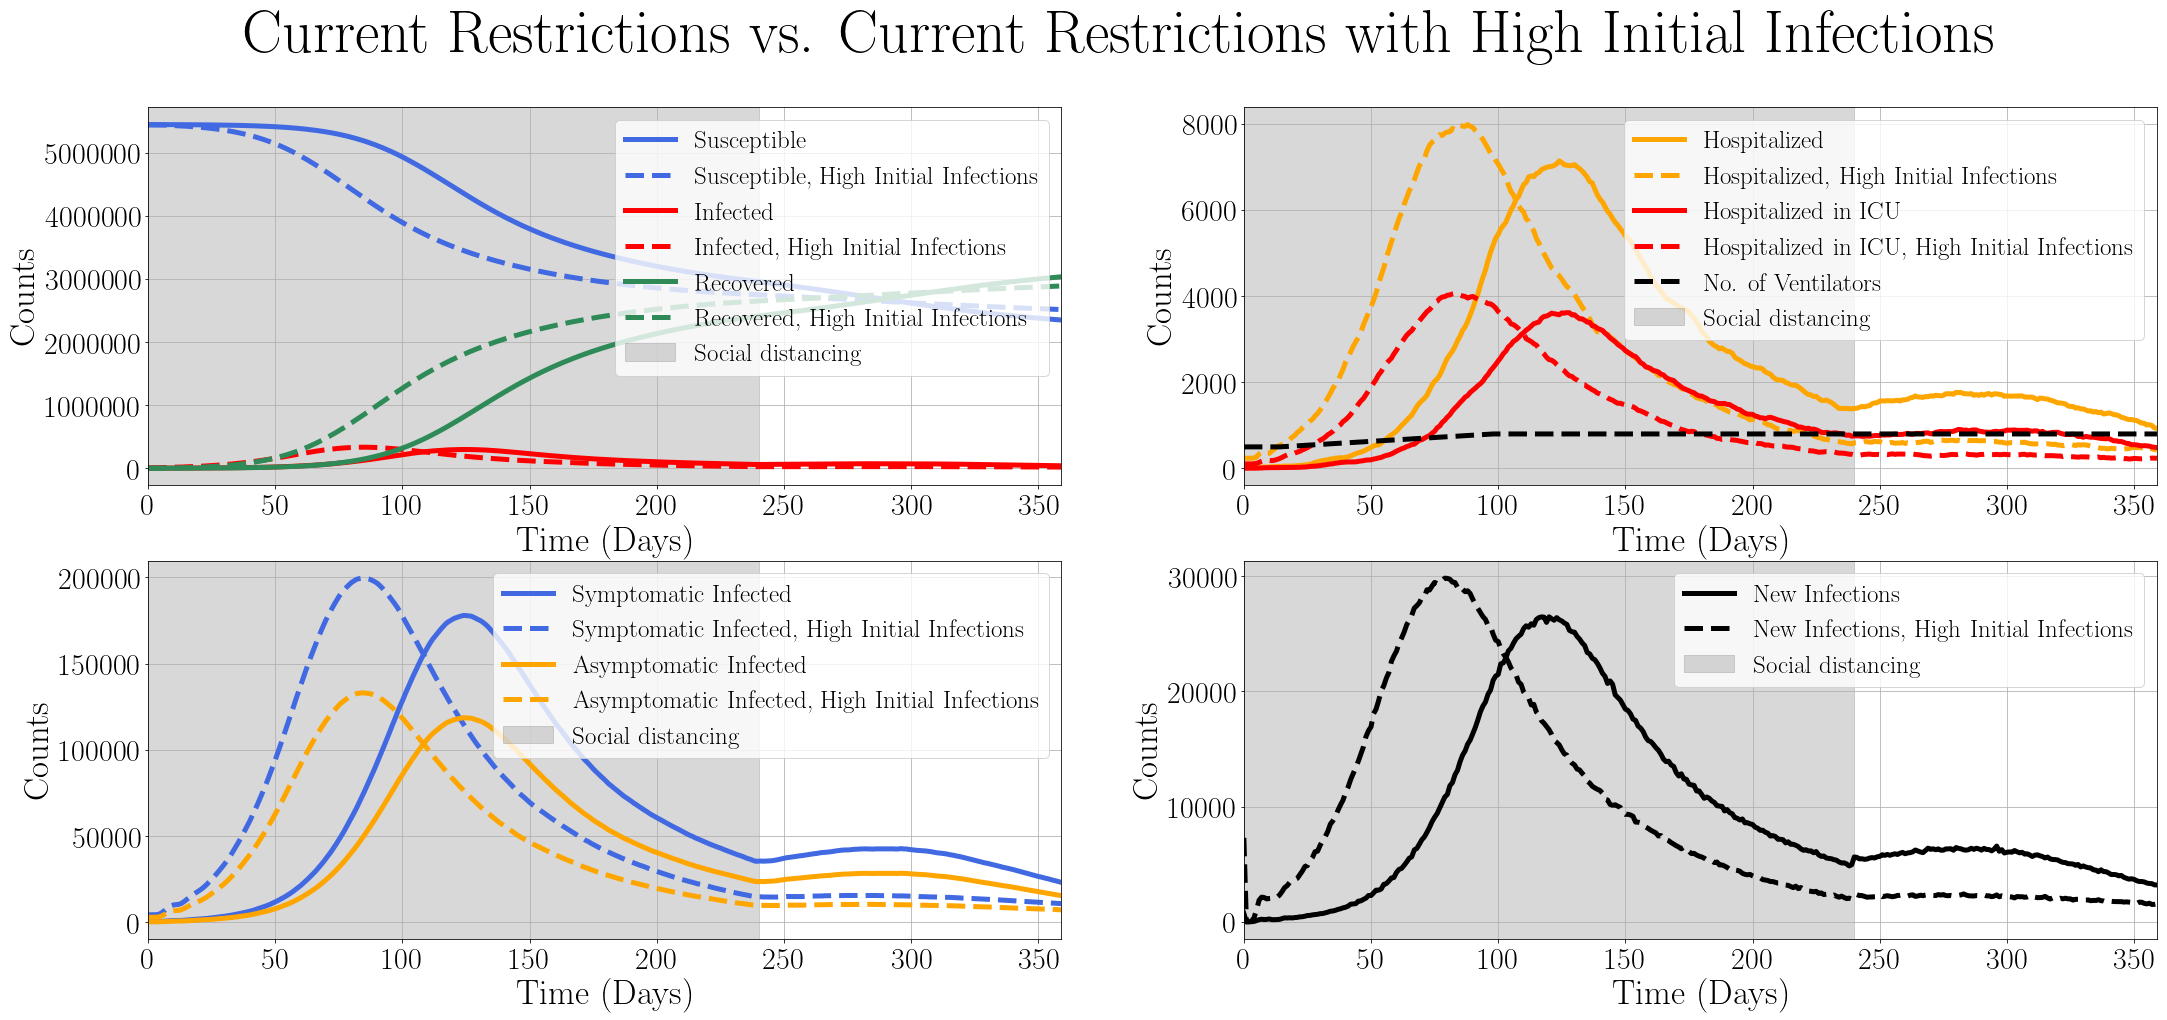

In [7]:
input_files_in = ['restrictions_and_quarantine.json','restrictions_and_quarantine_10.json']

plotting_time_course_two(input_files_in, 
                             plot_municipality=False, muni_string='Banská Bystrica',
                             plot_intermittent_NPI=False,
                             title_str='Current Restrictions vs. Current Restrictions with High Initial Infections',
                             asym_ratio=0.4,
                             t_measures_on=0, t_measures_off=240, measures_string='Social distancing',
                             t_ext_measures_on=None, t_ext_measures_off=None,
                             ext_measures_string='Social Distancing of Elderly',
                             t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                             plot_deaths=False)

In [8]:
input_files = ['business_as_usual.json','restrictions_and_quarantine.json','elderly_restricted.json','intermitent.json','superspreaders.json','blackout.json']

In [9]:
def get_relative_cumulative_and_peak_counts(input_files, base_file='business_as_usual.json',
                                            muni_string='Nitra', plot_municipality=False,
                                            save_fig_str='relative_counts.csv'):
    
    # Initialize the vector of cumulative infected
    Cum_R_vec = np.zeros(len(input_files))

    # Initialize the vector of cumulative dead
    Cum_D_vec = np.zeros(len(input_files))

    # Initialize the vector of peak hospitalized
    Peak_H_vec = np.zeros(len(input_files))

    # Initialize the vector of peak ICU hospitalized
    Peak_ICU_vec = np.zeros(len(input_files))

    # Initialize the number of peak new cases
    Peak_NC_vec = np.zeros(len(input_files))

    # Empty list of strings
    str_list = []

    for ind in range(len(input_files)):

        # Get the name strings
        str_list.append(input_files[ind].split('.')[0])

        # Select the index of the value agains which
        # the rest of the values is compared
        if input_files[ind] == base_file:
            comp_ind = ind

        # Read the json file into Python
        with open(input_files[ind],'r') as input_f:
            input_data = json.load(input_f)

        df = pd.DataFrame(input_data['data'])
        df_muni = pd.DataFrame(input_data['city_names'])

        # Rename the column of municipalities
        df_muni.columns = ['muni_name']

        # Get the ID of the town
        town_id = df_muni.loc[df_muni['muni_name'] == muni_string].index[0]

        # Empty lists of different states individuals
        S_vec = np.zeros(len(df)) # Susceptible
        I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
        Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
        Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
        R_vec = np.zeros(len(df)) # Recovered
        D_vec = np.zeros(len(df)) # Dead
        H_vec = np.zeros(len(df)) # Hospitalized
        C_vec = np.zeros(len(df)) # Hospitalized in ICU
        NC_vec = np.zeros(len(df)) # Newly infected individuals


        if plot_municipality == True:

            # Get the vector of states for the single town
            for i in range(len(df)):
                S_vec[i] = df['susceptible'][i][town_id]
                I_vec[i] = df['infected'][i][town_id]
                Sym_vec[i] = (1-asym_ratio) * I_vec[i]
                Asym_vec[i] = asym_ratio * I_vec[i]
                R_vec[i] = df['immune'][i][town_id]
                D_vec[i] = df['dead'][i][town_id]
                H_vec[i] = df['hospitalized'][i][town_id]
                C_vec[i] = df['critical_care'][i][town_id]
                NC_vec[i] = df['new_cases'][i][town_id]

        else:
            # Get the vectors of states for the whole country
            for i in range(len(df)):
                S_vec[i] = np.sum(df['susceptible'][i])
                I_vec[i] = np.sum(df['infected'][i])
                Sym_vec[i] = (1-asym_ratio) * I_vec[i]
                Asym_vec[i] = asym_ratio * I_vec[i]
                R_vec[i] = np.sum(df['immune'][i])
                D_vec[i] = np.sum(df['dead'][i])
                H_vec[i] = np.sum(df['hospitalized'][i])
                C_vec[i] = np.sum(df['critical_care'][i])
                NC_vec[i] = np.sum(df['new_cases'][i])

         # Get the cumulative number of infected
        Cum_R_vec[ind] = max(R_vec)

        # Get the cumulative number of dead
        Cum_D_vec[ind] = max(D_vec)

        # Get the peak number of hospitalized
        Peak_H_vec[ind] = max(H_vec)

        # Get the peak number of dead
        Peak_ICU_vec[ind] = max(C_vec)

        # Get the peak number of new infections
        Peak_NC_vec[ind] = max(NC_vec)

    # Get the vectors relative to the selected value
    Cum_R_vec = np.around((100*Cum_R_vec/Cum_R_vec[comp_ind]))
    Cum_D_vec = np.around(100*Cum_D_vec/Cum_D_vec[comp_ind])
    Peak_H_vec = np.around(100*Peak_H_vec/Peak_H_vec[comp_ind])
    Peak_ICU_vec = np.around(100*Peak_ICU_vec/Peak_ICU_vec[comp_ind])
    Peak_NC_vec = np.around(100*Peak_NC_vec/Peak_NC_vec[comp_ind])

    # Store the data into the DataFrame
    df_cum_peak = pd.DataFrame([Cum_R_vec, Cum_D_vec, Peak_H_vec, Peak_ICU_vec, Peak_NC_vec], 
                               index=['Relative Cumulative Infections','Relative Cumulative Deaths',
                                      'Relative Peak Hospitalizations ','Relative Peak ICU Demand','Relative Peak New Infections'], 
                               columns=['No restrictions','Restrictions for 240 days',
                                        'Restrictions for 50 days + above 60 isolation','Intermittent restrictions',
                                        'No restrictions + Super-spreaders','Lock-down'])

    # Export the data
    df_cum_peak.to_csv(save_fig_str)

    # Plot the data
    ax = df_cum_peak.plot.bar( rot=45, grid=True, figsize=(12,10), fontsize=20)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
              ncol=1, fancybox=True, shadow=True, fontsize=25)
    ax.set_ylabel('\% Relative counts', fontsize=25)
    
    return df_cum_peak

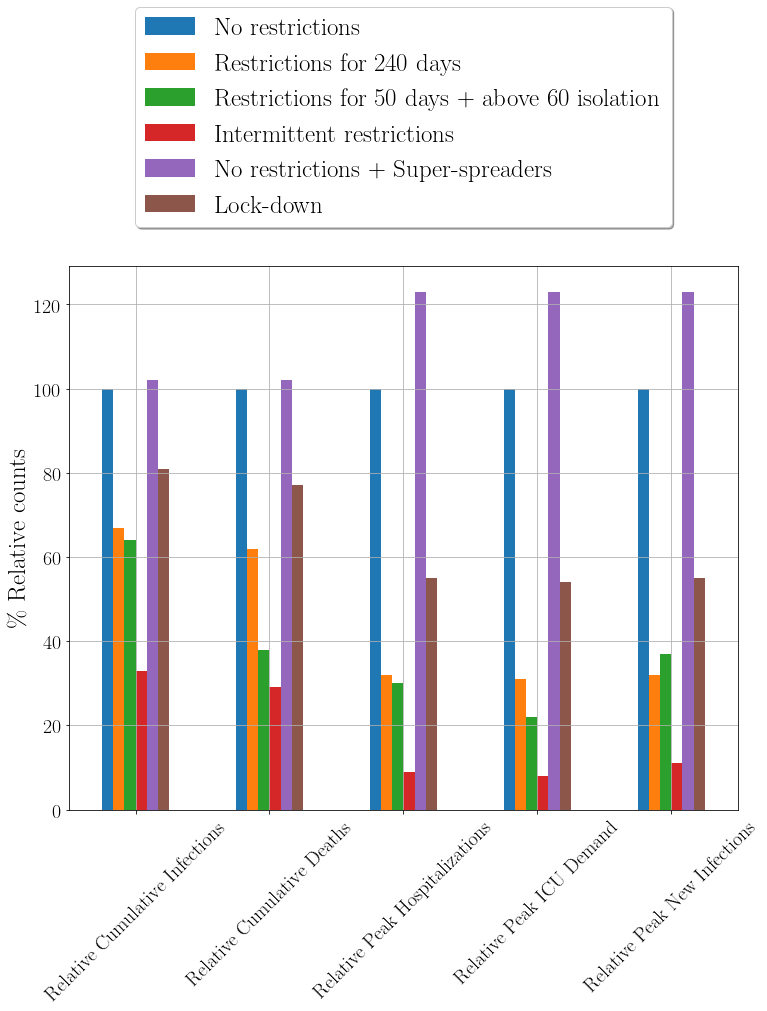

In [10]:
df_cum_peak = get_relative_cumulative_and_peak_counts(input_files)

In [11]:
def get_relative_sensitivity(input_files, base_file='business_as_usual.json',
                                            muni_string='Nitra', plot_municipality=False,
                                            save_fig_str='relative_counts.csv'):
    
    # Initialize the vector of cumulative infected
    Cum_R_vec = np.zeros(len(input_files))

    # Initialize the vector of cumulative dead
    Cum_D_vec = np.zeros(len(input_files))

    # Initialize the vector of peak hospitalized
    Peak_H_vec = np.zeros(len(input_files))

    # Initialize the vector of peak ICU hospitalized
    Peak_ICU_vec = np.zeros(len(input_files))

    # Initialize the number of peak new cases
    Peak_NC_vec = np.zeros(len(input_files))

    # Empty list of strings
    str_list = []

    for ind in range(len(input_files)):

        # Get the name strings
        str_list.append(input_files[ind].split('.')[0])

        # Select the index of the value agains which
        # the rest of the values is compared
        if input_files[ind] == base_file:
            comp_ind = ind

        # Read the json file into Python
        with open(input_files[ind],'r') as input_f:
            input_data = json.load(input_f)

        df = pd.DataFrame(input_data['data'])
        df_muni = pd.DataFrame(input_data['city_names'])

        # Rename the column of municipalities
        df_muni.columns = ['muni_name']

        # Get the ID of the town
        town_id = df_muni.loc[df_muni['muni_name'] == muni_string].index[0]

        # Empty lists of different states individuals
        S_vec = np.zeros(len(df)) # Susceptible
        I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
        Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
        Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
        R_vec = np.zeros(len(df)) # Recovered
        D_vec = np.zeros(len(df)) # Dead
        H_vec = np.zeros(len(df)) # Hospitalized
        C_vec = np.zeros(len(df)) # Hospitalized in ICU
        NC_vec = np.zeros(len(df)) # Newly infected individuals


        if plot_municipality == True:

            # Get the vector of states for the single town
            for i in range(len(df)):
                S_vec[i] = df['susceptible'][i][town_id]
                I_vec[i] = df['infected'][i][town_id]
                Sym_vec[i] = (1-asym_ratio) * I_vec[i]
                Asym_vec[i] = asym_ratio * I_vec[i]
                R_vec[i] = df['immune'][i][town_id]
                D_vec[i] = df['dead'][i][town_id]
                H_vec[i] = df['hospitalized'][i][town_id]
                C_vec[i] = df['critical_care'][i][town_id]
                NC_vec[i] = df['new_cases'][i][town_id]

        else:
            # Get the vectors of states for the whole country
            for i in range(len(df)):
                S_vec[i] = np.sum(df['susceptible'][i])
                I_vec[i] = np.sum(df['infected'][i])
                Sym_vec[i] = (1-asym_ratio) * I_vec[i]
                Asym_vec[i] = asym_ratio * I_vec[i]
                R_vec[i] = np.sum(df['immune'][i])
                D_vec[i] = np.sum(df['dead'][i])
                H_vec[i] = np.sum(df['hospitalized'][i])
                C_vec[i] = np.sum(df['critical_care'][i])
                NC_vec[i] = np.sum(df['new_cases'][i])

         # Get the cumulative number of infected
        Cum_R_vec[ind] = max(R_vec)

        # Get the cumulative number of dead
        Cum_D_vec[ind] = max(D_vec)

        # Get the peak number of hospitalized
        Peak_H_vec[ind] = max(H_vec)

        # Get the peak number of dead
        Peak_ICU_vec[ind] = max(C_vec)

        # Get the peak number of new infections
        Peak_NC_vec[ind] = max(NC_vec)

    # Get the vectors relative to the selected value
    Cum_R_vec = np.around((100*Cum_R_vec/Cum_R_vec[comp_ind]))
    Cum_D_vec = np.around(100*Cum_D_vec/Cum_D_vec[comp_ind])
    Peak_H_vec = np.around(100*Peak_H_vec/Peak_H_vec[comp_ind])
    Peak_ICU_vec = np.around(100*Peak_ICU_vec/Peak_ICU_vec[comp_ind])
    Peak_NC_vec = np.around(100*Peak_NC_vec/Peak_NC_vec[comp_ind])

    # Store the data into the DataFrame
    df_cum_peak = pd.DataFrame([Cum_R_vec, Cum_D_vec, Peak_H_vec, Peak_ICU_vec, Peak_NC_vec], 
                               index=['Relative Cumulative Infections','Relative Cumulative Deaths',
                                      'Relative Peak Hospitalizations ','Relative Peak ICU Demand','Relative Peak New Infections'], 
                               columns=['Current Restrictions (Baseline)',
                                        'Current Restrictions (Decreased Household Transmissions)',
                                        'Current Restrictions (10x initial infections)'])

    # Export the data
    df_cum_peak.to_csv(save_fig_str)

    # Plot the data
    ax = df_cum_peak.plot.bar( rot=45, grid=True, figsize=(12,10), fontsize=20)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
              ncol=1, fancybox=True, shadow=True, fontsize=25)
    ax.set_ylabel('\% Relative counts', fontsize=25)
    
    return df_cum_peak

,Current Restrictions (Baseline),Current Restrictions (Decreased Household Transmissions),Current Restrictions (10x initial infections)
Relative Cumulative Infections,100.0,59.0,95.0
Relative Cumulative Deaths,100.0,62.0,96.0
Relative Peak Hospitalizations,100.0,48.0,112.0
Relative Peak ICU Demand,100.0,48.0,112.0
Relative Peak New Infections,100.0,48.0,113.0


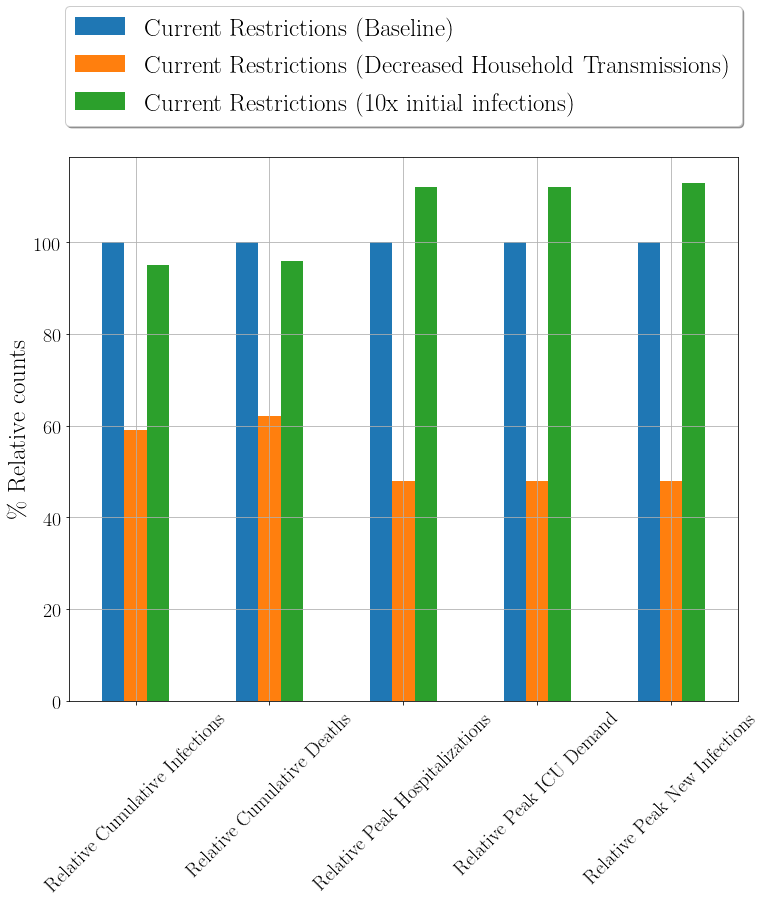

In [12]:
in_files = ['restrictions_and_quarantine.json','restrictions_and_quarantine_hp32.json','restrictions_and_quarantine_10.json']

get_relative_sensitivity(in_files, base_file='restrictions_and_quarantine.json',
                                            muni_string='Nitra', plot_municipality=False,
                                            save_fig_str='relative_counts_sensitivity.csv')

In [13]:
def get_NPI_vec(input_file, time_vec):

    # Read the JSON file into Python
    with open(input_file,'r') as input_file:
        input_data = json.load(input_file)
    
    # Get the starts and stops of the restrictions
    NPI_start = input_data['parameters']['restrictions_start']
    NPI_end = input_data['parameters']['restrictions_end']

    # Initialize the vector of restrictions
    NPI_vec = np.zeros(len(time_vec))

    # Plotting for the start and stop vectors of equal size
    if (len(NPI_start) == len(NPI_end)):

        for ind in range(len(NPI_start)):

            NPI_vec[np.arange(NPI_start[ind], NPI_end[ind])] = 1.0

    # Plotting for the start and stop vectors of unequal size
    elif (len(NPI_start) >= len(NPI_end)):

        for ind in range(len(NPI_end)):
            NPI_vec[np.arange(NPI_start[ind], NPI_end[ind])] = 1.0

        # Set the values until the end to 1.0
        NPI_vec[NPI_start[-1]:] = 1.0
        
    return NPI_vec

In [14]:
def plotting_time_course(input_file, 
                         plot_municipality=False, muni_string='Banská Bystrica', muni_name='',
                         plot_intermittent_NPI=False,
                         title_str='',
                         asym_ratio=0.4,
                         t_measures_on=None, t_measures_off=None, measures_string='Social distancing',
                         t_ext_measures_on=None, t_ext_measures_off=None,
                         ext_measures_string='Social Distancing of Elderly',
                         t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                         plot_deaths=False):
    """
    Plotting time course of the evolution of states.
    """
    
    # Read the JSON file into Python
    with open(input_file,'r') as input_f:
        input_data = json.load(input_f)
    
    # Convert the data into a dataframe
    df = pd.DataFrame(input_data["data"])
    df_muni = pd.DataFrame(input_data['city_names'])
    df_Reff = pd.DataFrame(input_data['R_eff'])
    
    # Get the time vector
    time_vec = np.arange(len(df))
    
    # If needed, get the vector of starts and stops 
    if plot_intermittent_NPI == True:
        NPI_vec = get_NPI_vec(input_file, time_vec)        
    
    # Rename the column of municipalities
    df_muni.columns = ['muni_name']
    
    # Get the ID of the town
    town_id = df_muni.loc[df_muni['muni_name'] == muni_string].index[0]
    
    # Empty lists of different states individuals
    S_vec = np.zeros(len(df)) # Susceptible
    I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
    Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
    R_vec = np.zeros(len(df)) # Recovered
    D_vec = np.zeros(len(df)) # Dead
    H_vec = np.zeros(len(df)) # Hospitalized
    C_vec = np.zeros(len(df)) # Hospitalized in ICU
    NC_vec = np.zeros(len(df)) # Newly infected individuals

    # Select whether to plot the data for single municipality
    # or the whole country
    if plot_municipality == True:
    
        # Get the vector of states for the single town
        for i in range(len(df)):
            S_vec[i] = df['susceptible'][i][town_id]
            I_vec[i] = df['infected'][i][town_id]
            Sym_vec[i] = (1-asym_ratio) * I_vec[i]
            Asym_vec[i] = asym_ratio * I_vec[i]
            R_vec[i] = df['immune'][i][town_id]
            D_vec[i] = df['dead'][i][town_id]
            H_vec[i] = df['hospitalized'][i][town_id]
            C_vec[i] = df['critical_care'][i][town_id]
            NC_vec[i] = df['new_cases'][i][town_id]
            
    else:
        # Get the vectors of states for the whole country
        for i in range(len(df)):
            S_vec[i] = np.sum(df['susceptible'][i])
            I_vec[i] = np.sum(df['infected'][i])
            Sym_vec[i] = (1-asym_ratio) * I_vec[i]
            Asym_vec[i] = asym_ratio * I_vec[i]
            R_vec[i] = np.sum(df['immune'][i])
            D_vec[i] = np.sum(df['dead'][i])
            H_vec[i] = np.sum(df['hospitalized'][i])
            C_vec[i] = np.sum(df['critical_care'][i])
            NC_vec[i] = np.sum(df['new_cases'][i])
        
    # Get the effective reproduction number R_eff array
    Reff_vec = np.array(df_Reff)
    
    # Get the number of ventilators
    num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)
      
    ###    
    ### Plotting
    ###
    fig, axes = plt.subplots(2,2, figsize=(36,14))
    fig.suptitle(title_str, fontsize=60,  y=1.05)
    fig.subplots_adjust(top=0.95)
    
    # Set the suptitle for the case of plotting only municipalities
    if plot_municipality == True:
        title_str = title_str + ' (' + muni_name + ')'
        fig.suptitle(title_str, fontsize=60, y=1.05)

    # Plot the S, I, R states
    axes[0, 0].plot(time_vec, S_vec, linewidth=5, label='Susceptible', color='royalblue')
    axes[0, 0].plot(time_vec, I_vec, linewidth=5, label='Infected', color='red')
    axes[0, 0].plot(time_vec, R_vec, linewidth=5, label='Recovered', color ='seagreen')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
        
    # Set x-axis limits
    axes[0, 0].set_xlim(time_vec[0], time_vec[-1])
    axes[0, 0].grid()
    
    # Set labels
    axes[0, 0].set_xlabel('Time (Days)', fontsize=35)
    axes[0, 0].set_ylabel('Counts', fontsize=35)
    axes[0, 0].tick_params(axis='x', labelsize=30)
    axes[0, 0].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[0, 0].legend(fontsize=25,loc='upper right')

    # Plot Hospitalzized and ICU states
    axes[0, 1].plot(time_vec, H_vec, linewidth=5, label='Hospitalized', color='orange')
    axes[0, 1].plot(time_vec, C_vec, linewidth=5, label='Hospitalized in ICU', color='red')
    
    if plot_municipality == False:
        axes[0, 1].plot(time_vec, num_vents, linestyle='--', linewidth=5, label='No. of Ventilators', color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0, 1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
        
    # Plotting start and stop of the control measures
    if plot_intermittent_NPI == True:
              
        # Get y-axis limits
        y_min, y_max = axes[0, 1].get_ylim()
        
        # Plot the restrictions
        axes[0, 1].plot(time_vec, NPI_vec*y_max, linewidth=5, label='Restrictions', color='grey')

    # Set x-axis limits
    axes[0, 1].set_xlim(time_vec[0], time_vec[-1])
    axes[0, 1].grid()
    

    # Set axis labels
    axes[0, 1].set_xlabel('Time (Days)', fontsize=35)
    axes[0, 1].set_ylabel('Counts', fontsize=35)
    axes[0, 1].tick_params(axis='x', labelsize=30)
    axes[0, 1].tick_params(axis='y', labelsize=30)

    # Set the legend 
    axes[0, 1].legend(fontsize=25,loc='upper right')

    # Plot Symptomatic and Asymptomatic Infected Cases
    axes[1, 0].plot(time_vec, Sym_vec, linewidth=5, label='Symptomatic Infected', color='orange')
    axes[1, 0].plot(time_vec, Asym_vec, linewidth=5, label='Asymptomatic Infected', color='royalblue')
#     axes[1, 0].plot(time_vec, NC_vec, linewidth=5, label='New Infections', color='red')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[1, 0].plot(time_vec, D_vec, linewidth=5, label='Cumulative Deaths', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
        
    # Plotting start and stop of the control measures
    if plot_intermittent_NPI == True:
              
        # Get y-axis limits
        y_min, y_max = axes[1, 0].get_ylim()
        
        # Plot the restrictions
        axes[1, 0].plot(time_vec, NPI_vec*y_max, linewidth=5, label='Restrictions', color='grey')
           
    # Set x-axis limits
    axes[1, 0].set_xlim(time_vec[0], time_vec[-1])
    axes[1, 0].grid()

    # Set axis labels
    axes[1, 0].set_xlabel('Time (Days)', fontsize=35)
    axes[1, 0].set_ylabel('Counts', fontsize=35)
    axes[1, 0].tick_params(axis='x', labelsize=30)
    axes[1, 0].tick_params(axis='y', labelsize=30)
    
    # Set the legend 
    axes[1, 0].legend(fontsize=25,loc='upper right')
        
        
    # Plot the number of new cases
    axes[1, 1].plot(time_vec, NC_vec, linewidth=5, label='New Infections', color='black')
#     axes[1, 1].plot(time_vec, np.ones(len(Reff_vec)), linestyle='--', linewidth=5, color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1, 1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
        
    # Plotting start and stop of the control measures
    if plot_intermittent_NPI == True:
              
        # Get y-axis limits
        y_min, y_max = axes[1, 1].get_ylim()
        
        # Plot the restrictions
        axes[1, 1].plot(time_vec, NPI_vec*y_max, linewidth=5, label='Restrictions', color='grey')
        
    # Set x-axis limits
    axes[1, 1].set_xlim(time_vec[0], time_vec[-1])
    axes[1, 1].grid()

    # Set axis labels
    axes[1, 1].set_xlabel('Time (Days)', fontsize=35)
    axes[1, 1].set_ylabel('Counts', fontsize=35)
    axes[1, 1].tick_params(axis='x', labelsize=30)
    axes[1, 1].tick_params(axis='y', labelsize=30)
    
    # Set the legend 
    axes[1, 1].legend(fontsize=25,loc='upper right')

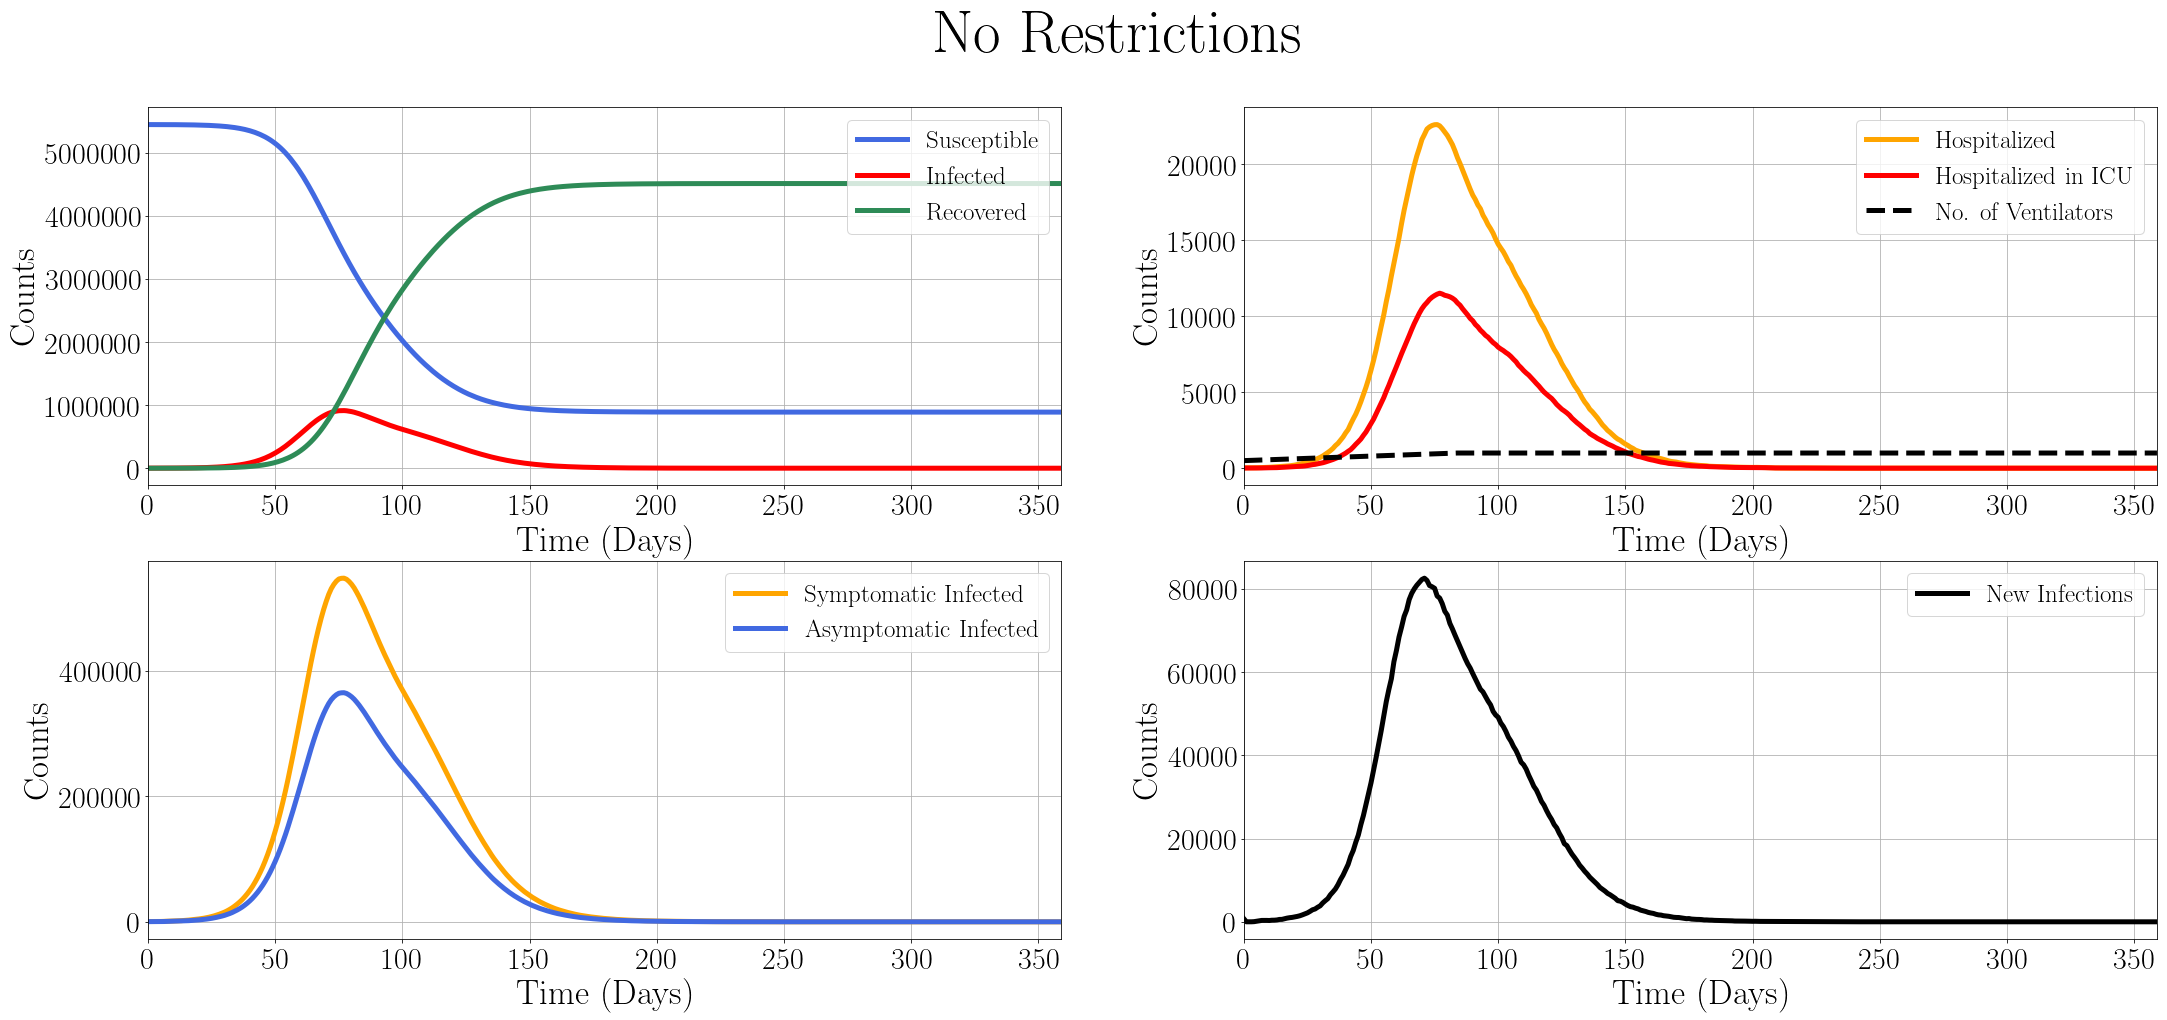

In [15]:
plotting_time_course('business_as_usual.json',
                     plot_municipality=False,
                     title_str='No Restrictions',
                     t_measures_on=None, t_measures_off=None,
                     t_ext_measures_on=None, t_ext_measures_off=None,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

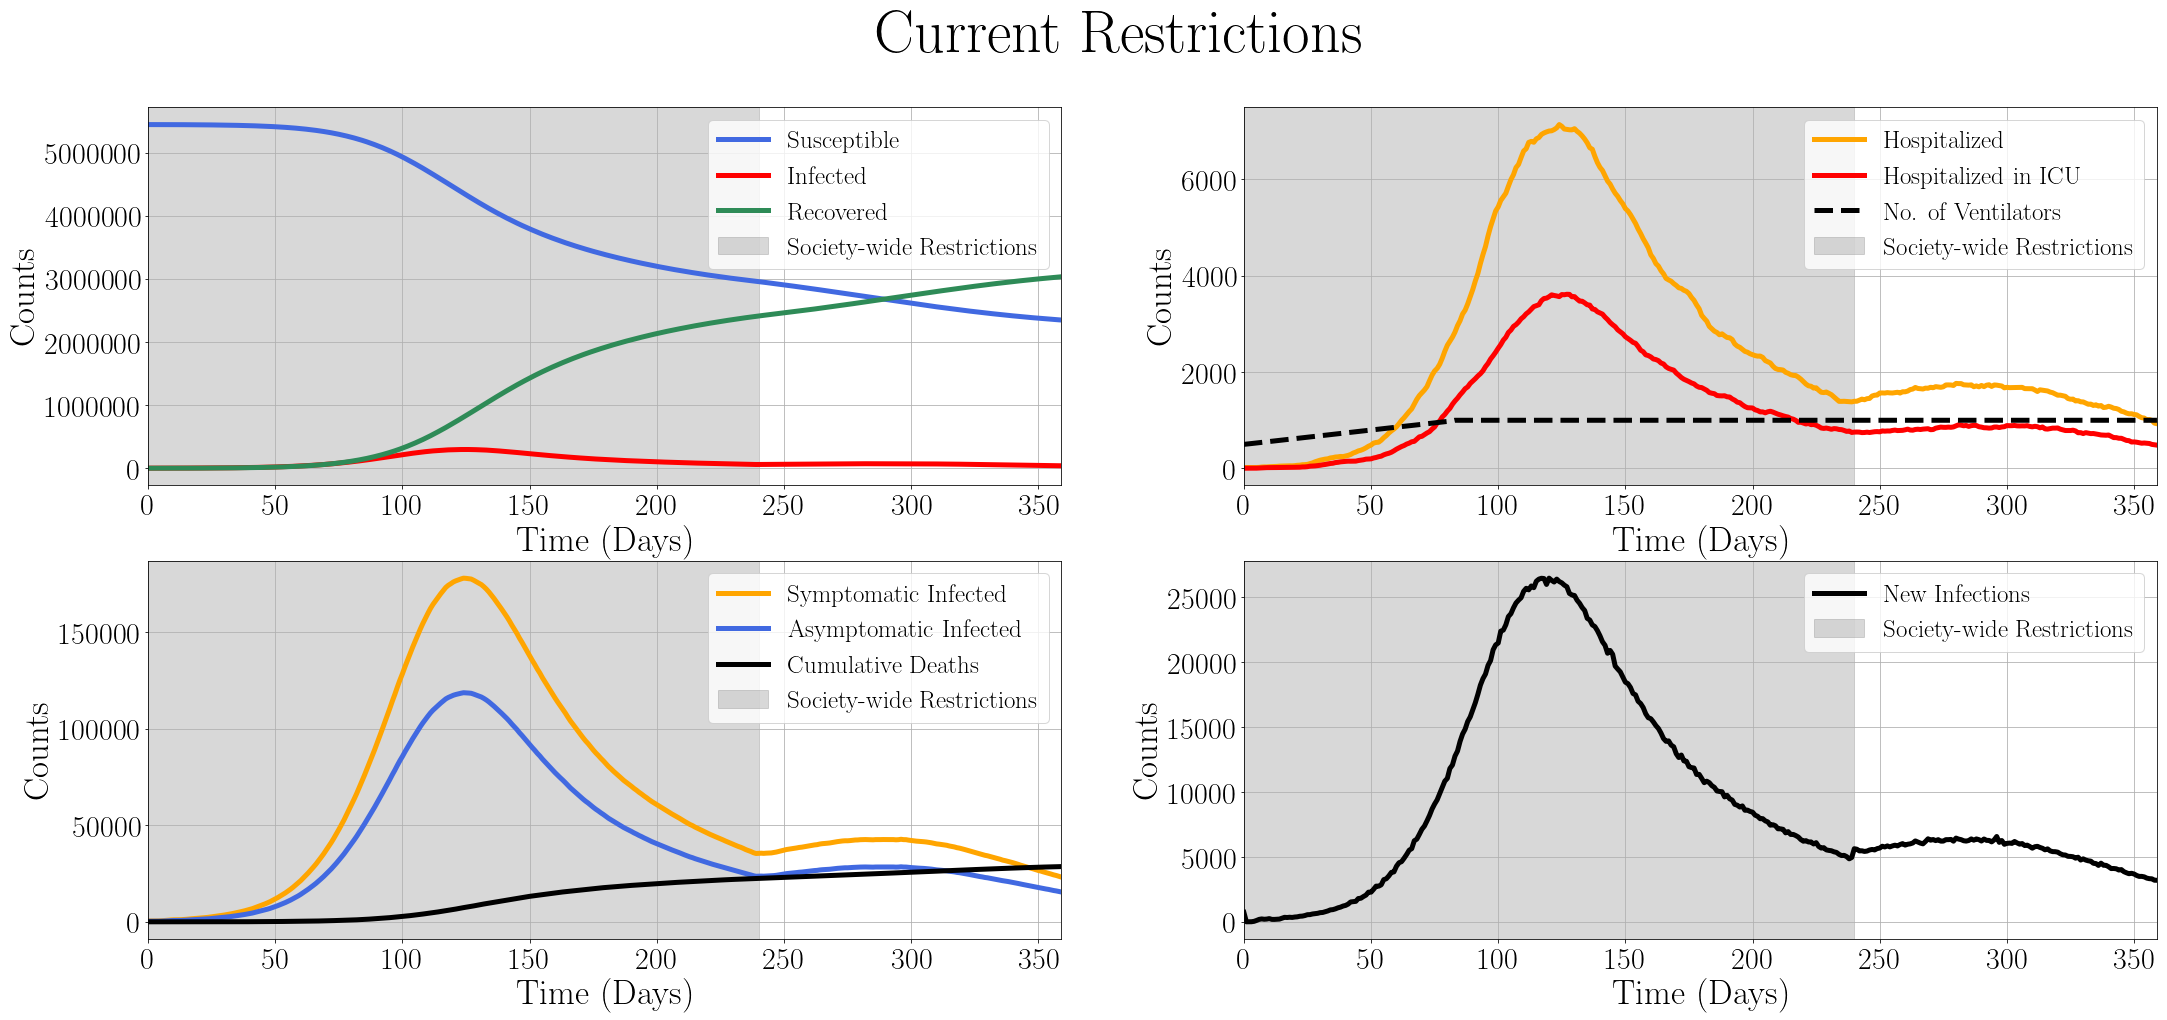

In [16]:
plotting_time_course('restrictions_and_quarantine.json', 
                     plot_municipality=False,
                     title_str='Current Restrictions',
                     t_measures_on=0, t_measures_off=240, measures_string='Society-wide Restrictions',
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=True)

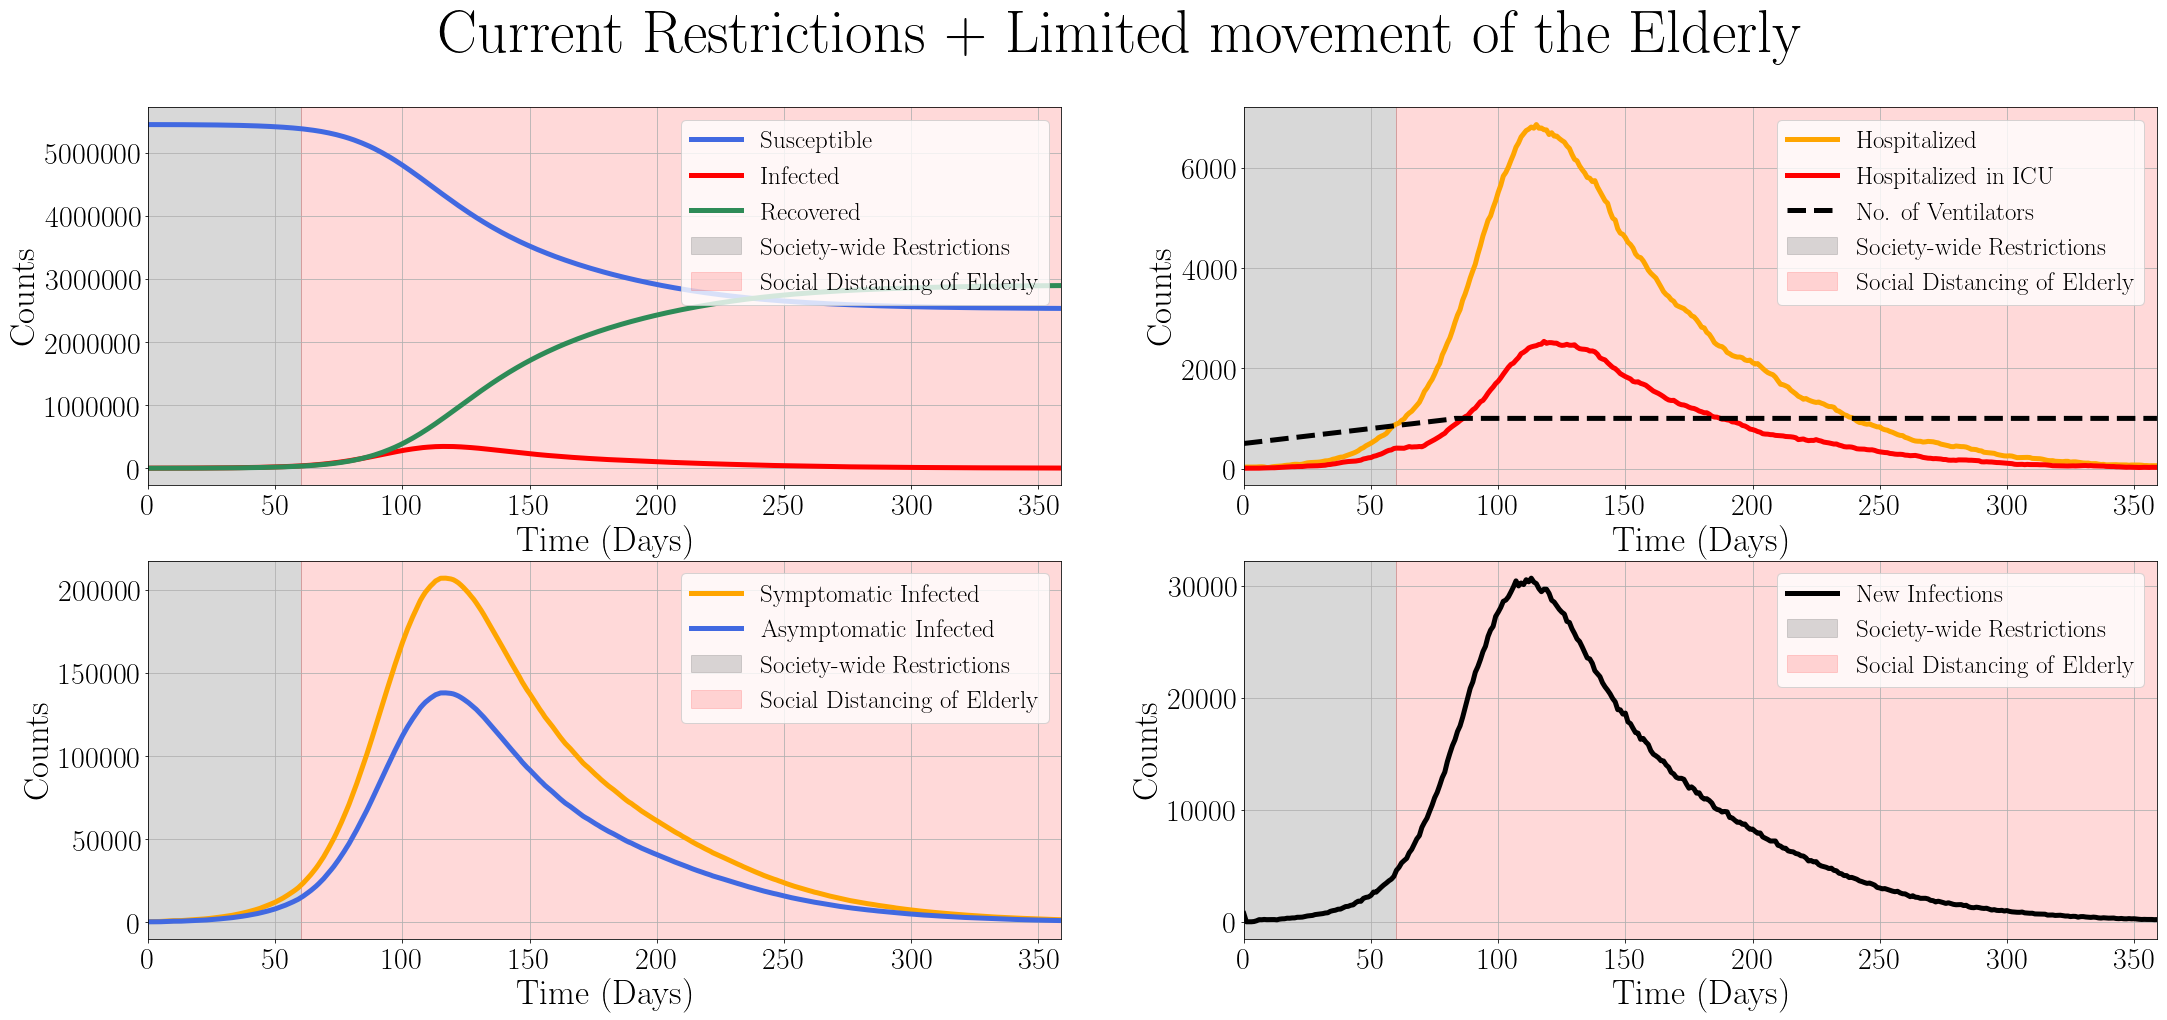

In [17]:
plotting_time_course('elderly_restricted.json', 
                     plot_municipality=False,
                     title_str='Current Restrictions + Limited movement of the Elderly ',
                     t_measures_on=0, t_measures_off=60, measures_string='Society-wide Restrictions',
                     t_ext_measures_on=60, t_ext_measures_off=360, ext_measures_string='Social Distancing of Elderly',
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

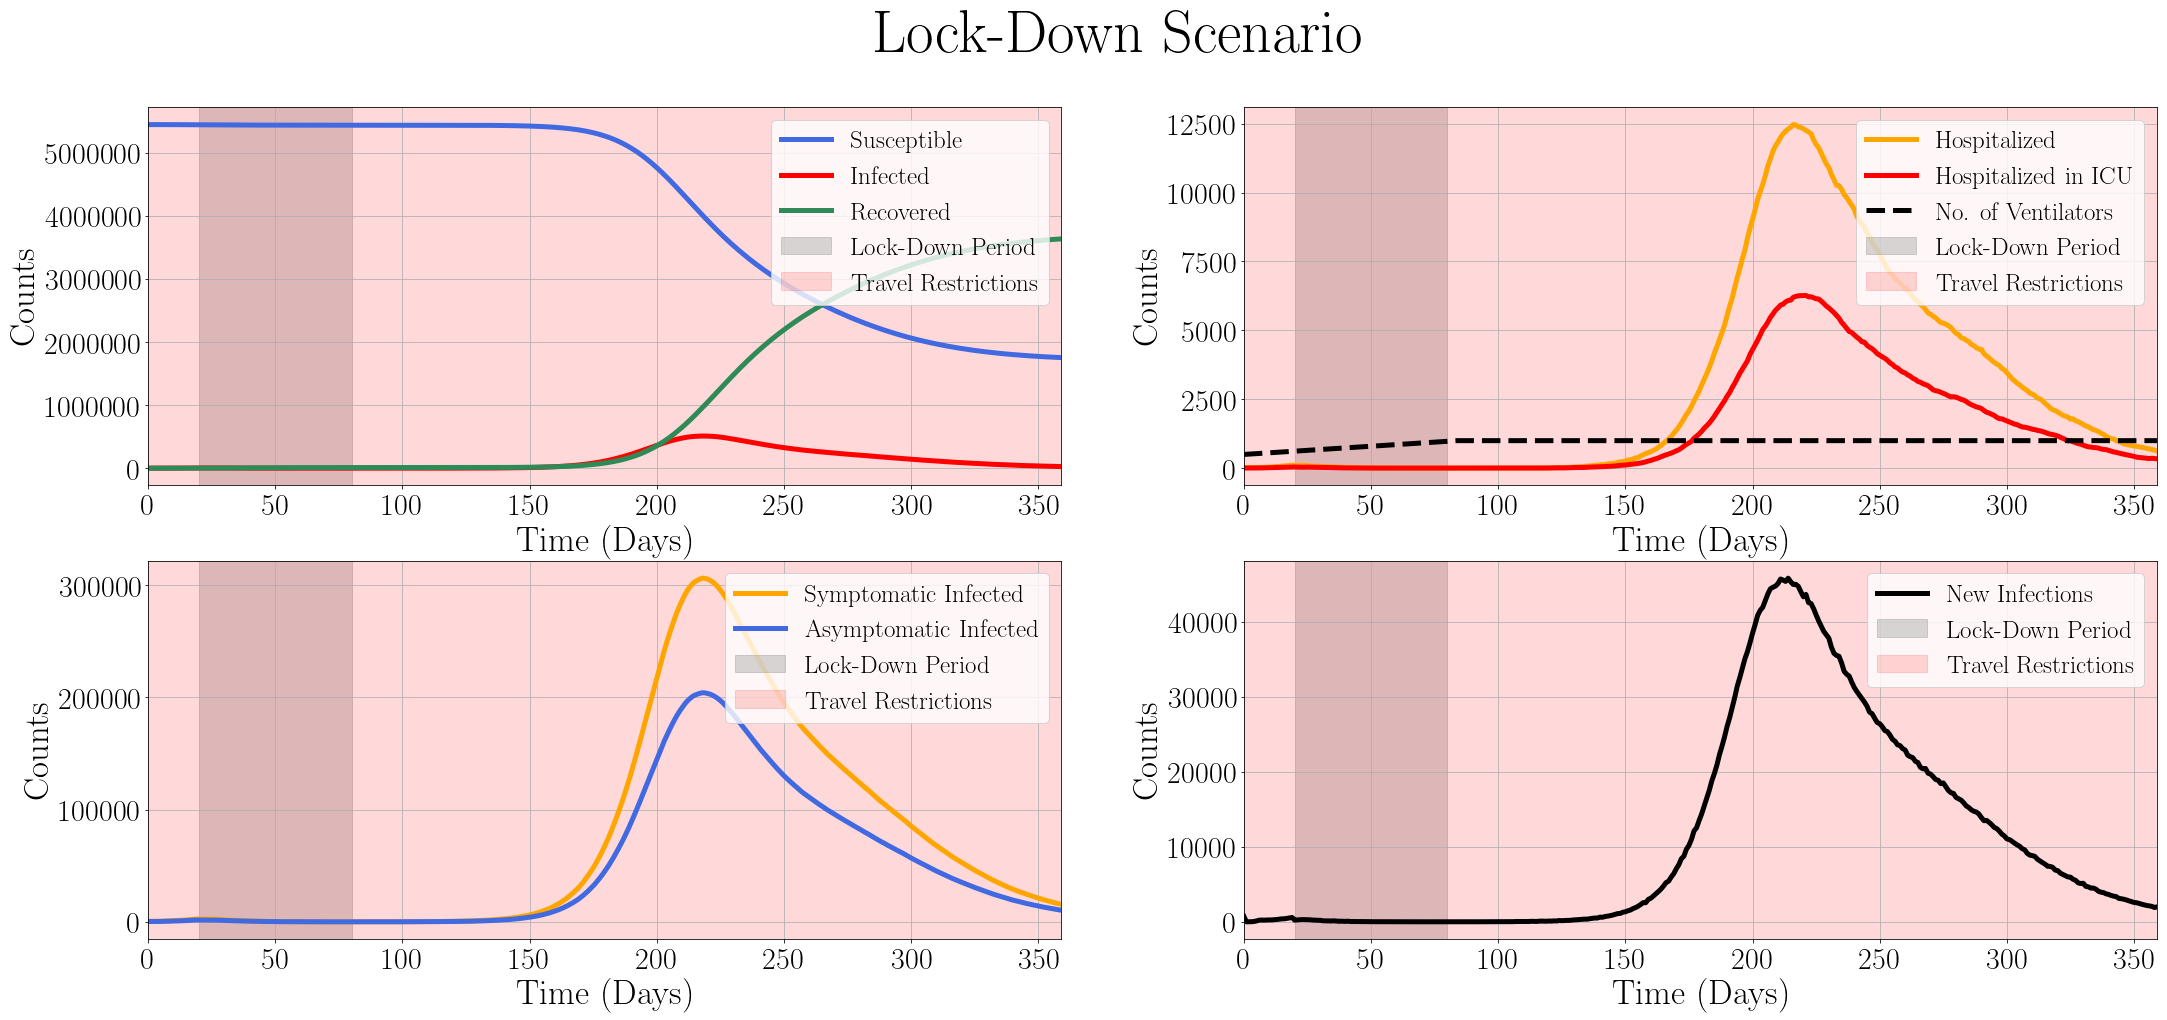

In [18]:
plotting_time_course('blackout.json', 
                     plot_municipality=False,
                     title_str='Lock-Down Scenario',
                     t_measures_on=20, t_measures_off=80, measures_string='Lock-Down Period',
                     t_ext_measures_on=0, t_ext_measures_off=360, ext_measures_string='Travel Restrictions',
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

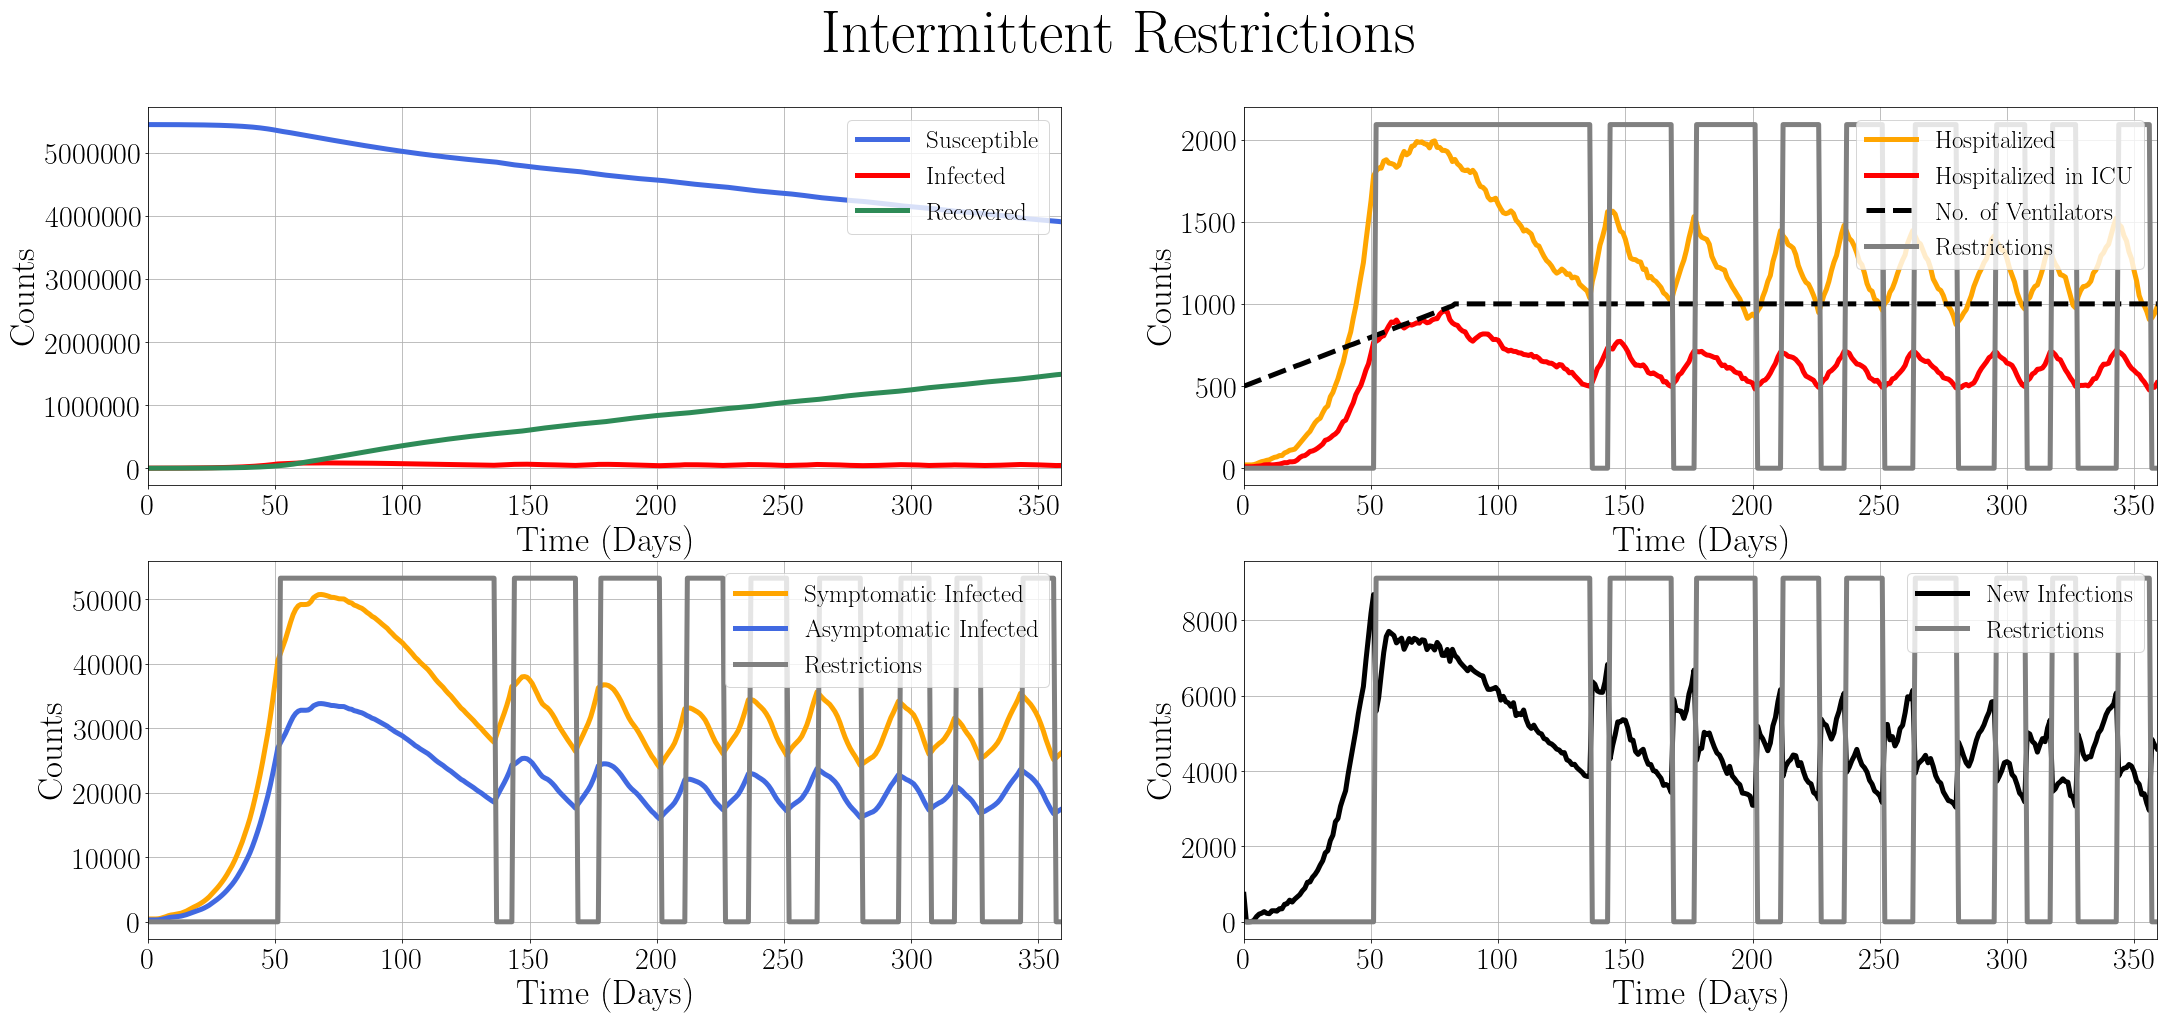

In [19]:
plotting_time_course('intermitent.json', 
                     plot_municipality=False,
                     title_str='Intermittent Restrictions',
                     plot_intermittent_NPI=True,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

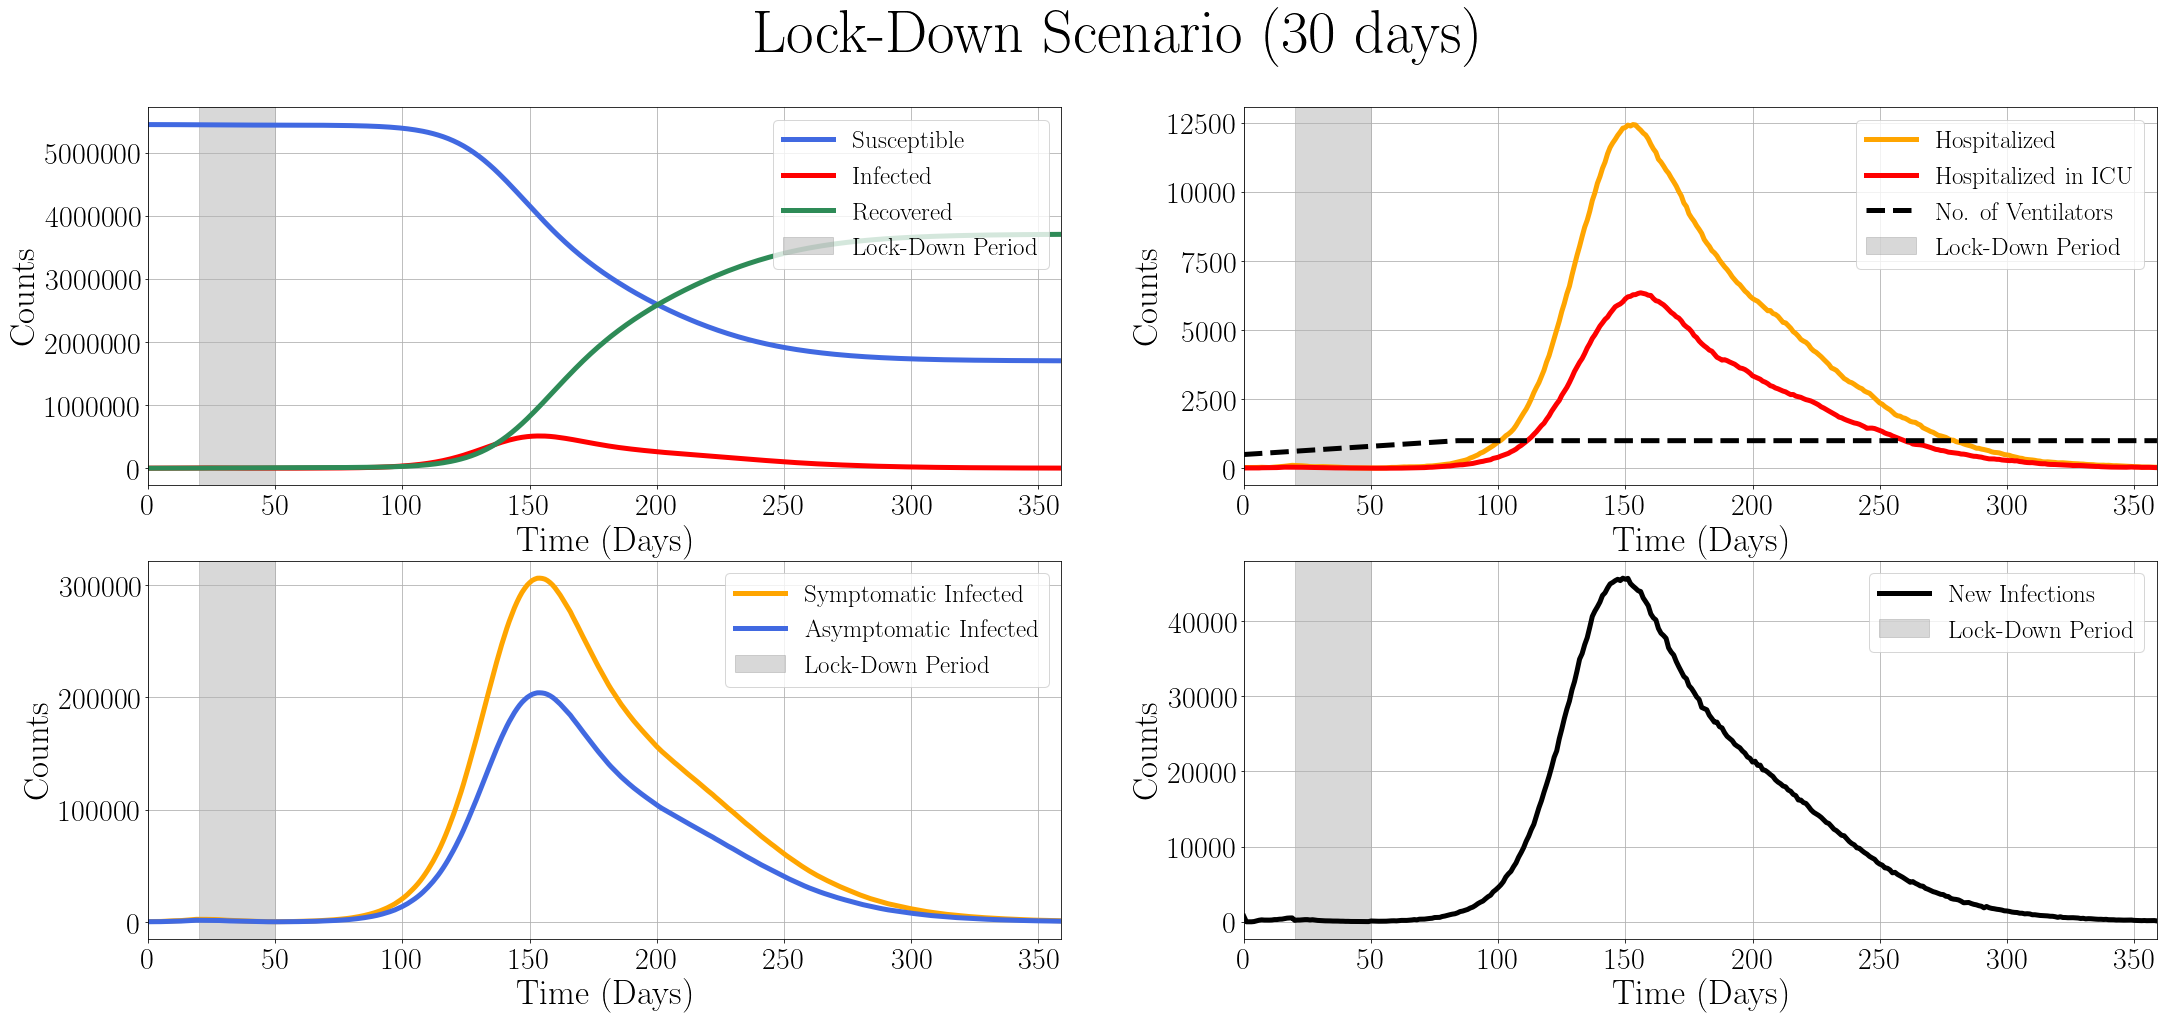

In [28]:
plotting_time_course('blackout-30.json', 
                     plot_municipality=False,
                     title_str='Lock-Down Scenario (30 days)',
                     t_measures_on=20, t_measures_off=50, measures_string='Lock-Down Period',
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

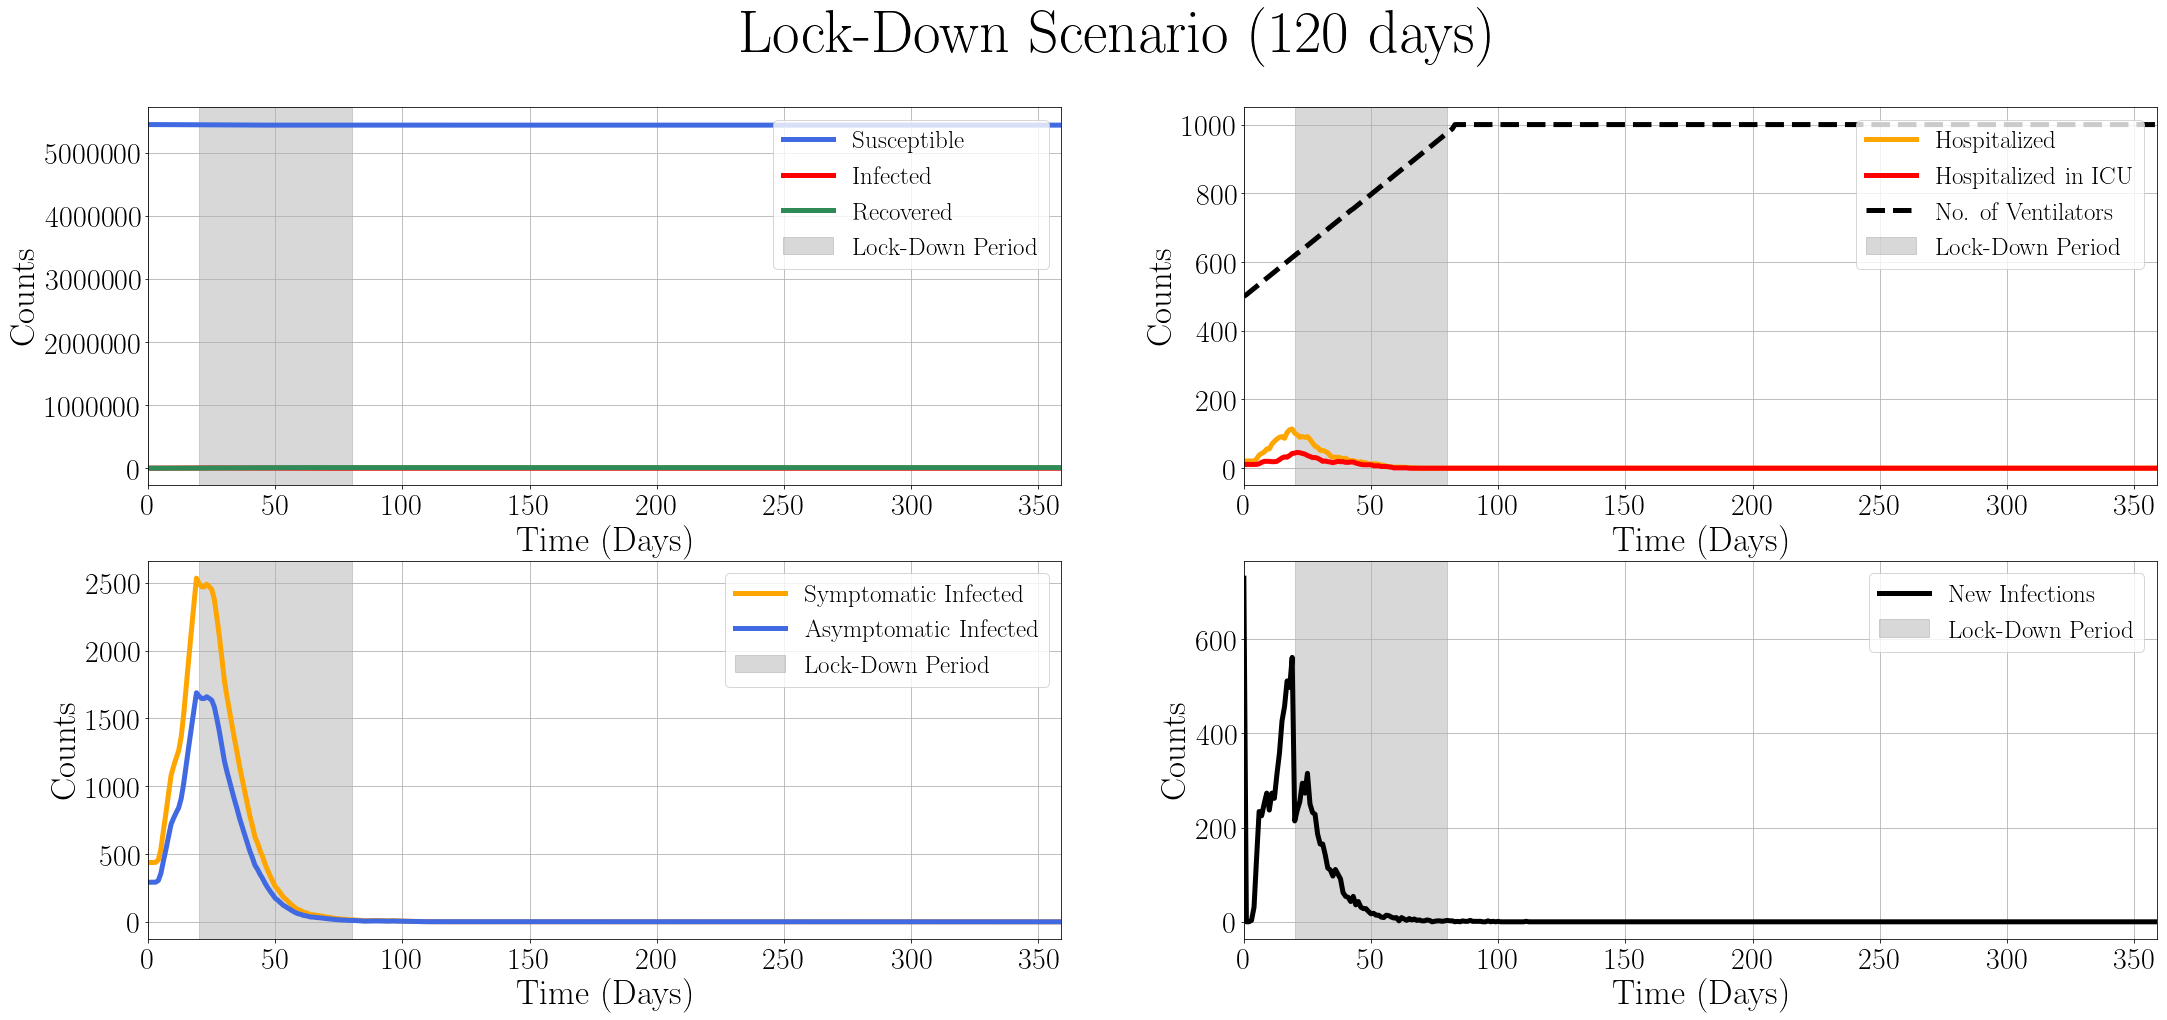

In [29]:
plotting_time_course('blackout-100.json', 
                     plot_municipality=False,
                     title_str='Lock-Down Scenario (120 days)',
                     t_measures_on=20, t_measures_off=80, measures_string='Lock-Down Period',
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

359
359


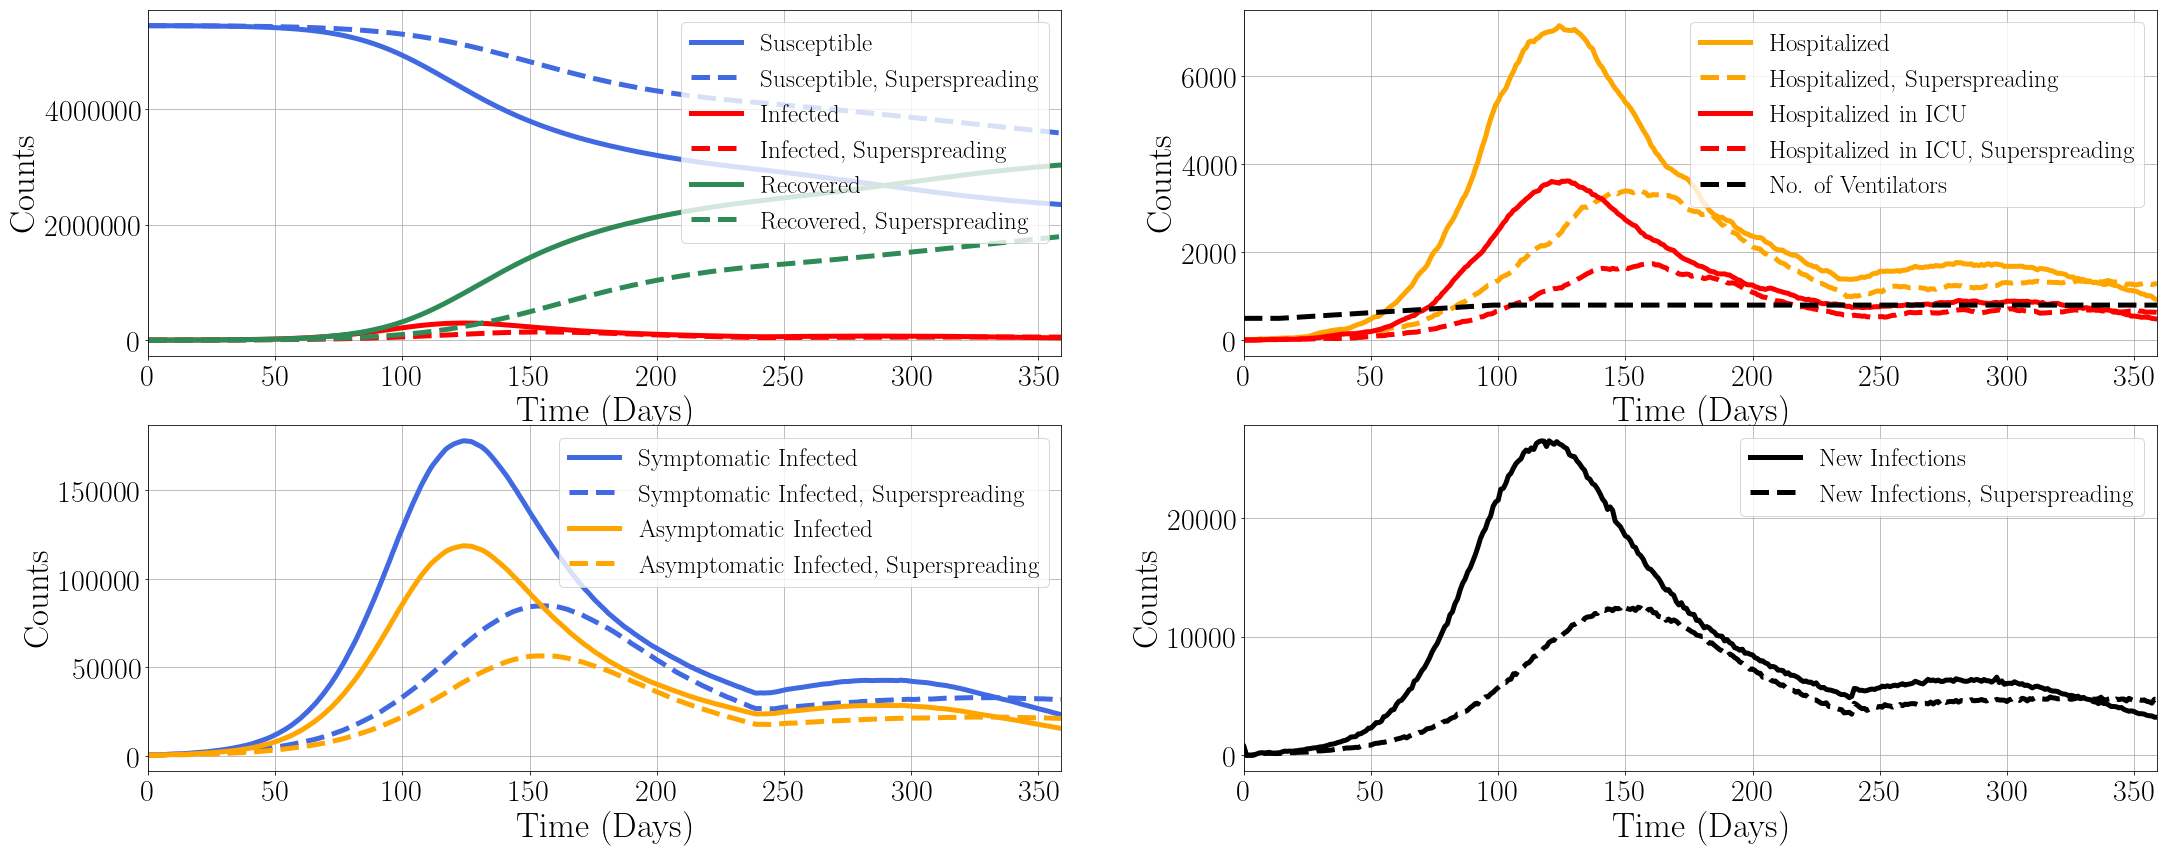

In [22]:
### Plotting

fig, axes = plt.subplots(2,2,figsize=(36,14))

# Plot the S, I, R states
# Plot the states
axes[0, 0].plot(time_vec_bas, S_vec_bas, linewidth=5, label='Susceptible', color='royalblue')
axes[0, 0].plot(time_vec_ss, S_vec_ss, linewidth=5, linestyle='--', label='Susceptible, Superspreading', color='royalblue')

axes[0, 0].plot(time_vec_bas, I_vec_bas, linewidth=5, label='Infected', color='red')
axes[0, 0].plot(time_vec_ss, I_vec_ss, linewidth=5,linestyle='--', label='Infected, Superspreading', color='red')

axes[0, 0].plot(time_vec_bas, R_vec_bas, linewidth=5, label='Recovered', color ='seagreen')
axes[0, 0].plot(time_vec_ss, R_vec_ss, linewidth=5, linestyle='--', label='Recovered, Superspreading', color ='seagreen')

# Set axis limits
t_bas_max = max(time_vec_bas)
t_ss_max = max(time_vec_ss)

time_vec_end = min(t_bas_max, t_ss_max)

print(t_bas_max)
axes[0, 0].set_xlim(time_vec_bas[0], time_vec_end)
axes[0, 0].grid()

# Set labels
axes[0, 0].set_xlabel('Time (Days)', fontsize=35)
axes[0, 0].set_ylabel('Counts', fontsize=35)
axes[0, 0].tick_params(axis='x', labelsize=30)
axes[0, 0].tick_params(axis='y', labelsize=30)

# Set the legend 
axes[0, 0].legend(fontsize=25,loc='upper right')



# Plot Hospitalized and ICU states
# Plot the states
axes[0, 1].plot(time_vec_bas, H_vec_bas, linewidth=5, label='Hospitalized', color='orange')
axes[0, 1].plot(time_vec_ss, H_vec_ss, linewidth=5, linestyle='--', label='Hospitalized, Superspreading', color='orange')

axes[0, 1].plot(time_vec_bas, C_vec_bas, linewidth=5, label='Hospitalized in ICU', color='red')
axes[0, 1].plot(time_vec_ss, C_vec_ss, linewidth=5,linestyle='--', label='Hospitalized in ICU, Superspreading', color='red')

axes[0, 1].set_xlim(time_vec_bas[0], time_vec_end)
axes[0, 1].grid()

# Plot num. of ventilators
num_vents = get_num_of_ventilators(time_vec_bas, t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)
axes[0, 1].plot(time_vec_bas, num_vents, linestyle='--', linewidth=5, label='No. of Ventilators', color='black')


# Set labels
axes[0, 1].set_xlabel('Time (Days)', fontsize=35)
axes[0, 1].set_ylabel('Counts', fontsize=35)
axes[0, 1].tick_params(axis='x', labelsize=30)
axes[0, 1].tick_params(axis='y', labelsize=30)

# Set the legend 
axes[0, 1].legend(fontsize=25,loc='upper right')


# # Plot Sympotmatic, Asymptomatic and New Cases
# Plot the states
axes[1, 0].plot(time_vec_bas, Sym_vec_bas, linewidth=5, label='Symptomatic Infected', color='royalblue')
axes[1, 0].plot(time_vec_ss, Sym_vec_ss, linewidth=5, linestyle='--', label='Symptomatic Infected, Superspreading', color='royalblue')

axes[1, 0].plot(time_vec_bas, Asym_vec_bas, linewidth=5, label='Asymptomatic Infected', color='orange')
axes[1, 0].plot(time_vec_ss, Asym_vec_ss, linewidth=5,linestyle='--', label='Asymptomatic Infected, Superspreading', color='orange')

# axes[1, 0].plot(time_vec_bas, NC_vec_bas, linewidth=5, label='New Infections', color ='red')
# axes[1, 0].plot(time_vec_ss, NC_vec_ss, linewidth=5, linestyle='--', label='New Infections, Superspreading', color ='red')


# axes[1, 0].plot(time_vec_bas, D_vec_bas, linewidth=5, label='Cumulative Deaths', color ='black')
# axes[1, 0].plot(time_vec_ss, D_vec_ss, linewidth=5, linestyle='--', label='Cumulative Deaths, SS', color ='black')

# Set axis limits
t_bas_max = max(time_vec_bas)
t_ss_max = max(time_vec_ss)

time_vec_end = min(t_bas_max, t_ss_max)

print(t_bas_max)
axes[1, 0].set_xlim(time_vec_bas[0], time_vec_end)
axes[1, 0].grid()

# Set labels
axes[1, 0].set_xlabel('Time (Days)', fontsize=35)
axes[1, 0].set_ylabel('Counts', fontsize=35)
axes[1, 0].tick_params(axis='x', labelsize=30)
axes[1, 0].tick_params(axis='y', labelsize=30)

# Set the legend 
axes[1, 0].legend(fontsize=25,loc='upper right')


# Plot the effective reproduction number
axes[1, 1].plot(time_vec_bas, NC_vec_bas, linewidth=5, label='New Infections', color='black')
axes[1, 1].plot(time_vec_ss, NC_vec_ss, linewidth=5,  linestyle='--', label='New Infections, Superspreading', color='black')
# axes[1, 1].plot(time_vec_bas, np.ones(len(Reff_bas)), linestyle='--', linewidth=5, color='black')

# Set x-axis limits
axes[1, 1].set_xlim(time_vec_bas[0], time_vec_end)
axes[1, 1].grid()

# Set axis labels
axes[1, 1].set_xlabel('Time (Days)', fontsize=35)
axes[1, 1].set_ylabel('Counts', fontsize=35)
axes[1, 1].tick_params(axis='x', labelsize=30)
axes[1, 1].tick_params(axis='y', labelsize=30)

# Set the legend 
axes[1, 1].legend(fontsize=25,loc='upper right')

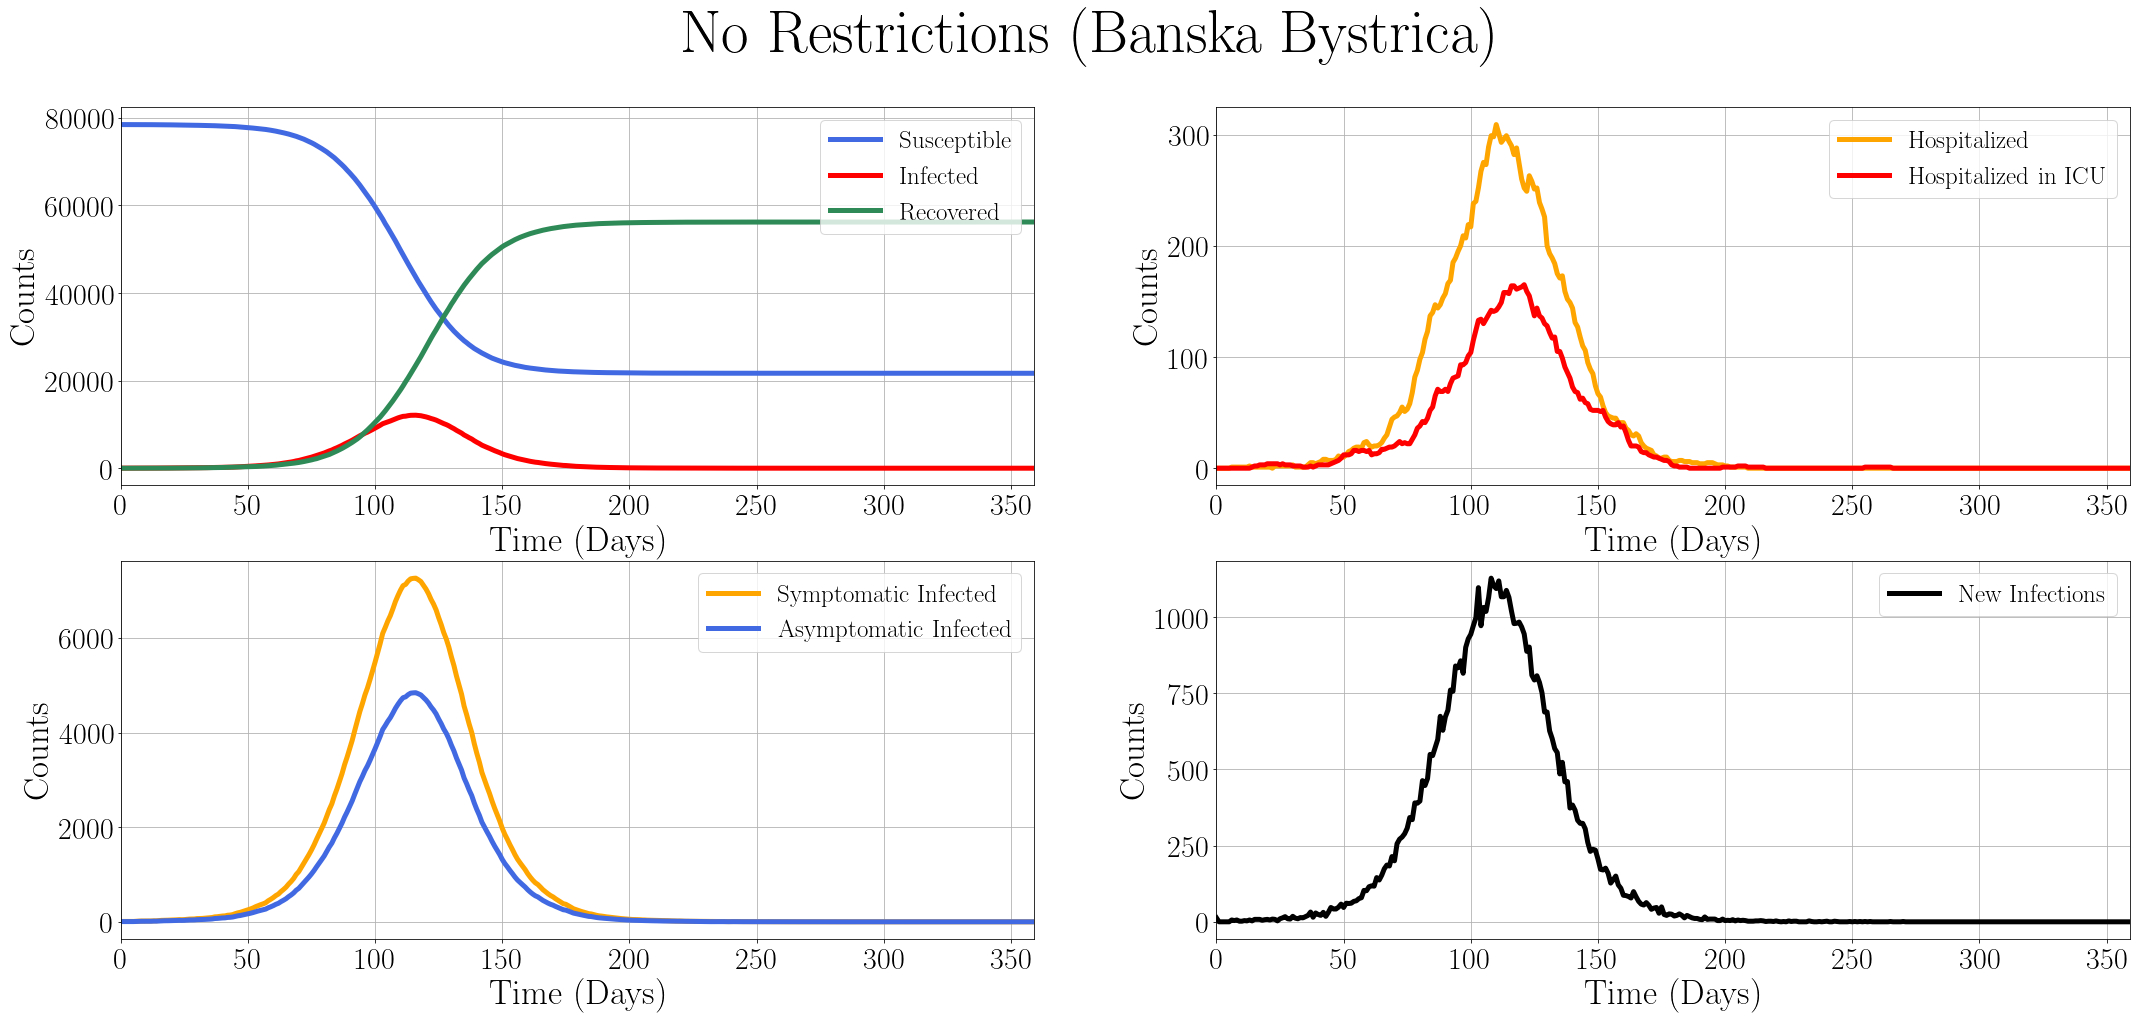

In [23]:
plotting_time_course('business_as_usual.json',
                     plot_municipality=True, muni_name='Banska Bystrica',
                     title_str='No Restrictions',
                     t_measures_on=None, t_measures_off=None,
                     t_ext_measures_on=None, t_ext_measures_off=None,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

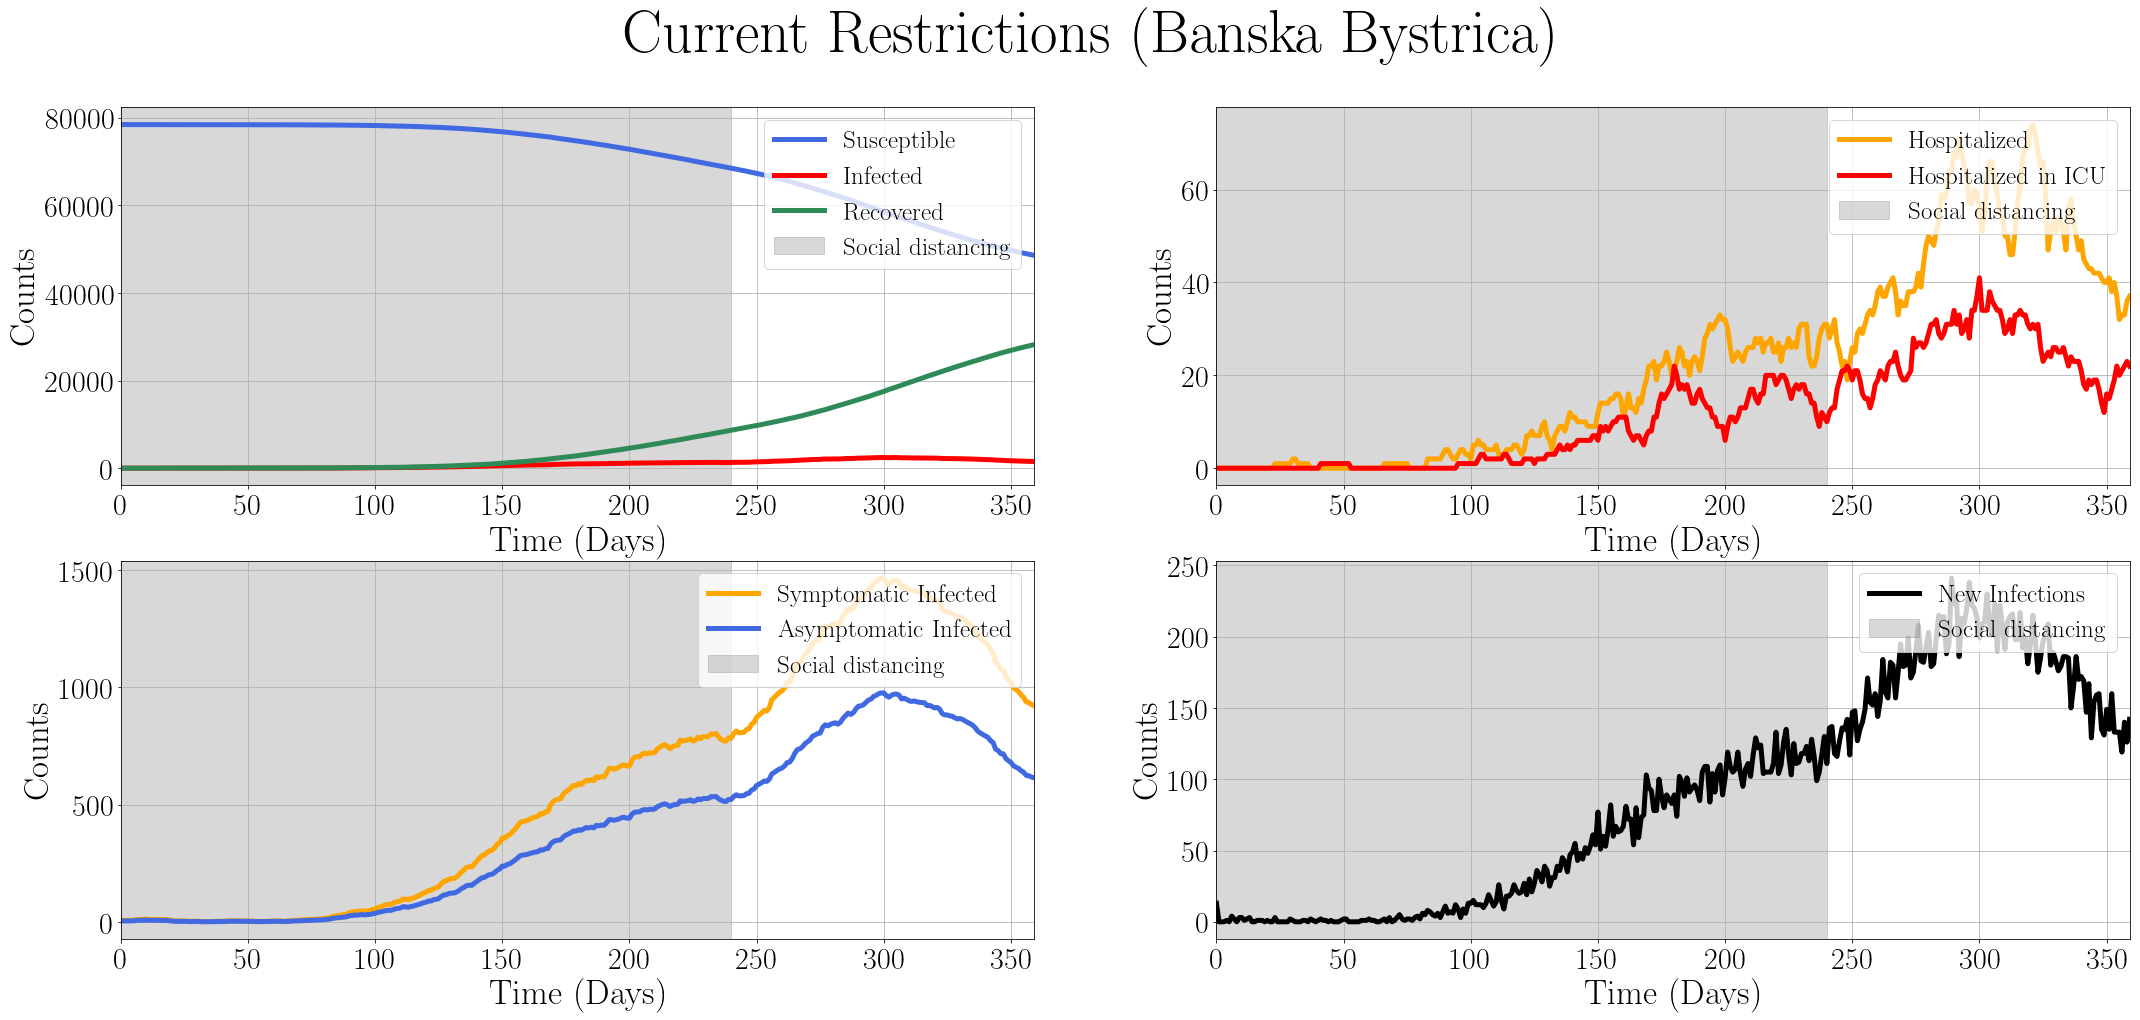

In [24]:
plotting_time_course('restrictions_and_quarantine.json',
                     plot_municipality=True, muni_name='Banska Bystrica',
                     title_str='Current Restrictions',
                     t_measures_on=0, t_measures_off=240,
                     t_ext_measures_on=None, t_ext_measures_off=None,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

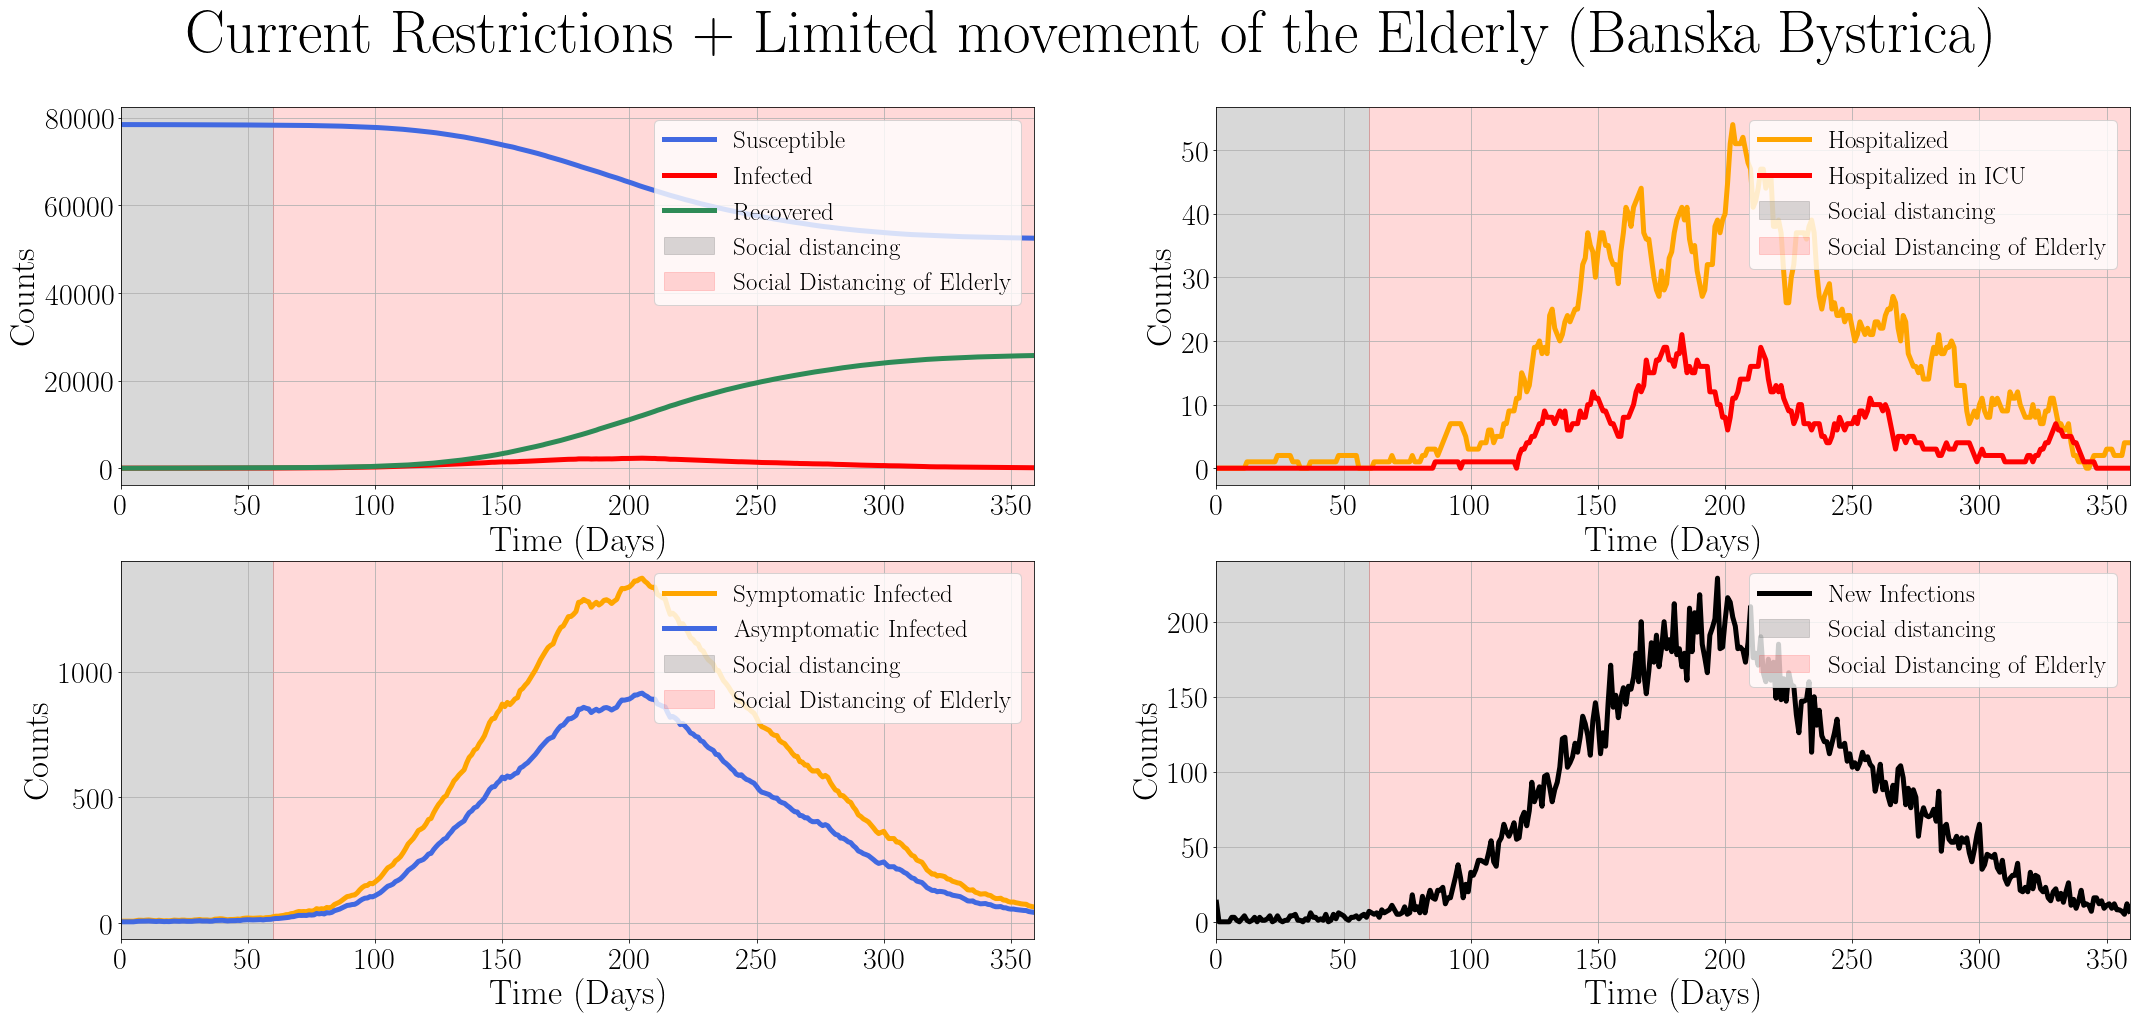

In [25]:
plotting_time_course('elderly_restricted.json',
                     plot_municipality=True, muni_name='Banska Bystrica',
                     title_str='Current Restrictions + Limited movement of the Elderly',
                     t_measures_on=0, t_measures_off=60,
                     t_ext_measures_on=60, t_ext_measures_off=360,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

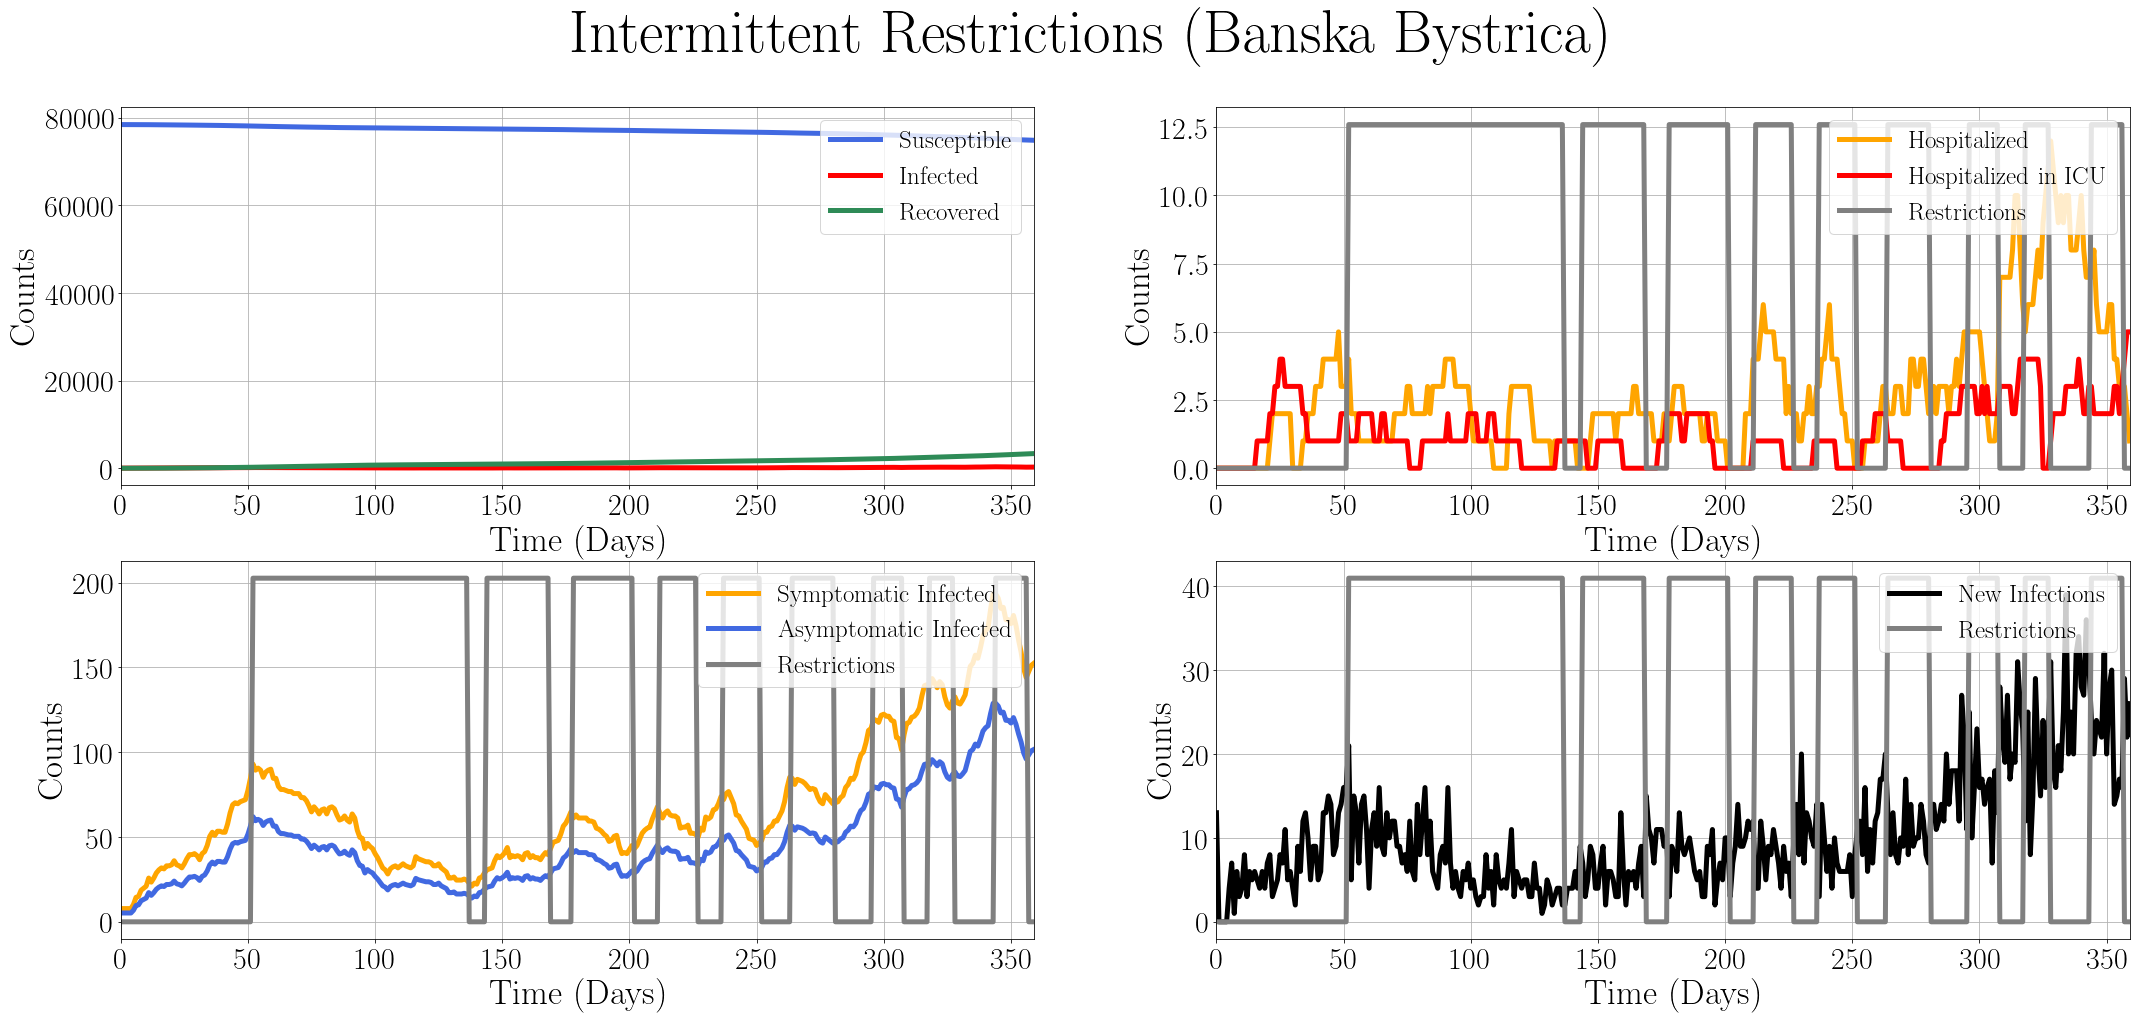

In [26]:
plotting_time_course('intermitent.json',
                     plot_municipality=True, muni_name='Banska Bystrica',
                     title_str='Intermittent Restrictions',
                     plot_intermittent_NPI=True,
                     t_measures_on=None, t_measures_off=None,
                     t_ext_measures_on=None, t_ext_measures_off=None,
                     t_start_adding_vents=0, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=1000,
                     plot_deaths=False)

In [27]:
plotting_time_course('elderly-limited.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800)

KeyError: 'R_eff'

In [ ]:
plotting_time_course('current-restrictions.json',
                     plot_municipality=True,
                     t_measures_on=10, t_measures_off=240,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=False)

What we will present tomorrow: 
1. **Do-nothing scenario**
2. **Restrictions on the movement of elderly (above 60 years):**
    * Everything as usual.
    * Restrict the mobility of the elderly to 20%.
3. **Current scenario:**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7%
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined.
    * Every day, there are 1,000 tests made on the people who met the infected. 
      If these tests show that these people have COVID-19, they are also quarantined.
4. **Intermittent social distancing**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7%
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined.
    * Every day, there are 1,000 tests made on the people who met the infected. 
      If these tests show that these people have COVID-19, they are also quarantined.
    * If number of ICU cases decreases below 20% of the current ICU capacity, then switch the social distancing OFF.
    * If number of ICU cases increases above 40$ of the current ICU capacity, then switch the social distancing ON.

In [ ]:
def plotting_time_course_Slovak(input_file, asym_ratio,
                                t_measures_on=None, t_measures_off=None, measures_string='Doba opatreni',
                                t_ext_measures_on=None, t_ext_measures_off=None,
                                ext_measures_string='Doba izolacie seniorov',
                                t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                                plot_deaths=False):
    """
    Plotting time course of the evolution of states.
    """
    
    # Read the JSON file into Python
    with open(input_file,'r') as input_file:
        input_data = json.load(input_file)

    # Convert the data into a dataframe
    df = pd.DataFrame(input_data["data"])
    
    # Empty lists of different states individuals
    S_vec = np.zeros(len(df)) # Susceptible
    I_vec = np.zeros(len(df)) # Infected (Symptomatic + Asymptomatic)
    Sym_vec = np.zeros(len(df)) # Symptomatic Individuals
    Asym_vec = np.zeros(len(df)) # Asymptomatic indiviudals 
    R_vec = np.zeros(len(df)) # Recovered
    D_vec = np.zeros(len(df)) # Dead
    H_vec = np.zeros(len(df)) # Hospitalized
    C_vec = np.zeros(len(df)) # Hospitalized in ICU
    NC_vec = np.zeros(len(df)) # Newly infected individuals

    # Get the time vector
    time_vec = np.arange(len(df))

    # Get the vectors of states
    for i in range(len(df)):
        S_vec[i] = np.sum(df['susceptible'][i])
        I_vec[i] = np.sum(df['infected'][i])
        Sym_vec[i] = (1-asym_ratio) * I_vec[i]
        Asym_vec[i] = asym_ratio * I_vec[i]
        R_vec[i] = np.sum(df['immune'][i])
        D_vec[i] = np.sum(df['dead'][i])
        H_vec[i] = np.sum(df['hospitalized'][i])
        C_vec[i] = np.sum(df['critical_care'][i])
        NC_vec[i] = np.sum(df['new_cases'][i])
        
    # Get the number of ventilators
    num_vents = get_num_of_ventilators(time_vec, t_start_adding_vents, num_weeks_adding_vents, num_vent_init, num_vent_end)
        
    ### Plotting
    fig, axes = plt.subplots(1,3,figsize=(28,6))

    # Plot the S, I, R states
    # Plot the states
    axes[0].plot(time_vec, S_vec, linewidth=2.5, label='Nachylni', color='royalblue')
    axes[0].plot(time_vec, I_vec, linewidth=2.5, label='Infikovani', color='red')
    axes[0].plot(time_vec, R_vec, linewidth=2.5, label='Zotaveni', color ='seagreen')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[0].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set axis limits
    axes[0].set_xlim(time_vec[0], time_vec[-1])
    axes[0].grid()

    # Set labels
    axes[0].set_xlabel('Cas (Dni)', fontsize=20)
    axes[0].set_ylabel('Pocty', fontsize=20)
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[0].legend(fontsize=15,loc='best')

    # Plot Hospitalzized and ICU states
    # Plot the states
    axes[1].plot(time_vec, H_vec, linewidth=2.5, label='Hospitalizovani', color='orange')
    axes[1].plot(time_vec, C_vec, linewidth=2.5, label='Hospitalizovani na JIS', color='red')
    axes[1].plot(time_vec, num_vents, linestyle='--', linewidth=3, label='Pocet ventilatorov', color='black')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')
        
    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[1].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')

    # Set axis limits
    axes[1].set_xlim(time_vec[0], time_vec[-1])
    axes[1].grid()

    # Set axis labels
    axes[1].set_xlabel('Cas (Dni)', fontsize=20)
    axes[1].set_ylabel('Pocty', fontsize=20)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)


    # Set the legend 
    axes[1].legend(fontsize=15,loc='best')

    # Plot Symptomatic and Asymptomatic Infected Cases
    # Plot the states
    # axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Dead', color='black')
    axes[2].plot(time_vec, Sym_vec, linewidth=2.5, label='Symptomaticki Infikovani', color='orange')
    axes[2].plot(time_vec, Asym_vec, linewidth=2.5, label='Asymptomaticki Infikovani', color='royalblue')
    axes[2].plot(time_vec, NC_vec, linewidth=2.5, label='Nove Infekcie', color='red')

    # Plotting measures period
    if t_measures_on is not None and t_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_measures_on, t_measures_off, alpha=0.3, label=measures_string, color='grey')

    # Plotting deaths
    if plot_deaths == True:
        axes[2].plot(time_vec, D_vec, linewidth=2.5, label='Kumulativne Umrtia', color='black')

    # Plotting extended measures period
    if t_ext_measures_on is not None and t_ext_measures_off is not None:  
        # Fill the portion of graph when blackout is on
        axes[2].axvspan(t_ext_measures_on, t_ext_measures_off, alpha=0.15, label=ext_measures_string, color='red')
    
    # Set axis limits
    axes[2].set_xlim(time_vec[0], time_vec[-1])
    axes[2].grid()

    # Set axis labels
    axes[2].set_xlabel('Cas (Dni)', fontsize=20)
    axes[2].set_ylabel('Pocet', fontsize=20)
    axes[2].tick_params(axis='x', labelsize=15)
    axes[2].tick_params(axis='y', labelsize=15)

    # Set the legend 
    axes[2].legend(fontsize=15,loc='best')
        

In [ ]:
plotting_time_course('business-as-usual.json', asym_ratio, t_measures_on=None, t_measures_off=None,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

Scenario: `quarantene.json`
In this case, we assume:
* Mobility as usual
* Quarantined individuals have reduced infectiousness to 20%
* Quarantine starts 1 day after the start of infectiousness
* 

In [ ]:
plotting_time_course('double-peak.json', asym_ratio, t_measures_on=10, t_measures_off=240,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

In [ ]:
plotting_time_course('blackout.json', asym_ratio, t_measures_on=40, t_measures_off=100,
                     measures_string='Blackout period',
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

**Current scenario:**
* Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
* OD matrix multiplied by 0.7
* Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined. Only those who are infectious and symptomatic, after one day of the symptoms, have probability of transmission reduced to 20%.
* Every day, there are 1,500 tests made on the people who met the infected. We compute the probability of catching the infected person num_tests/(num_infected * num_meetings) -> probability that infected is tested. If these tests show that these people have COVID-19, they are also quarantined.

In [ ]:
plotting_time_course('elderly-limited.json',
                     plot_municipality=False,
                     t_measures_on=10, t_measures_off=50,
                            t_ext_measures_on=50, t_ext_measures_off=260,
                     t_start_adding_vents=14, num_weeks_adding_vents=12, num_vent_init=500, num_vent_end=800,
                     plot_deaths=True)

**Elderly limited:**
* 10 days nothing (since 16th March, but this can vary)
* After 10 days current restrictions, current scenario occurs
**Current scenario:**
    * Google mobility reports estimates to compute the out-of-households contacts within the city (reduced to 52%)
    * OD matrix multiplied by 0.7
    * Quarantined people have probability of transmission reduced to 20%. Only those with symptoms are quarantined. Only those who are  
      infectious and symptomatic, after one day of the symptoms, have probability of transmission reduced to 20%.
    * Every day, there are 1,500 tests made on the people who met the infected. We compute the probability of catching the infected person 
      num_tests/(num_infected * num_meetings) -> probability that infected is tested. If these tests show that these people have COVID-19, 
      they are also quarantined.
      
* After 50 days from the beginning, switch off the current-restrictions and only keep the elderly-limited (reduced mobility to 20% for people aged 60y)

**ICU-limited**
* Business as usual for the first 10 days
* If ICU capacity is filled to 70%, switch on the following NPI: 
    * Reduce random contacts to 40%
    * No testing, tracing, etc.
* If ICU capacity is filled to 50%, switch OFF the NPI.
* Assuming 1000 ICU/LV

**Blackout**
* Business as usual for the first 40 days
* For next 60 days, switch on the NPI:
    * Reduce the number of random contacts to 5% 
* After 100 days,release the restrictions
